분석 모델 - 랜덤 포레스트
분류와 회귀에 사용되는 지도 학습 알고리즘. 여러 개의 의사결정나무를 조합한 모델. 


In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
os.chdir("/Users/leejuan/Documents/GitHub/senior-road-risk-analyzer")
print("✅ 작업 경로 변경 완료:", os.getcwd())
# 데이터 불러오기
df = pd.read_csv("./data/processed/accident_data_filtered.csv")
df.head()

✅ 작업 경로 변경 완료: /Users/leejuan/Documents/GitHub/senior-road-risk-analyzer


/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_55576/1929682364.py:8: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/processed/accident_data_filtered.csv")


,acdnt_year,occrrnc_time_code,legaldong_name,acdnt_hdc,lrg_violt_1_dc,road_stle_dc,wrngdo_vhcle_asort_dc,acdnt_age_1_code,rdse_sttus_dc,road_div,...,near_child_zone,near_elderly_zone,near_disabled_zone,lanes,lengths,velocity,traffic_volume,elderly_hotspot,non_elderly_hotspot,all_hotspot
0,2021,4,서울특별시 강남구 일원동,차대사람,안전운전불이행,교차로 - 교차로부근,승용,32,건조,105.0,...,1,0,1,8.0,17101.0,26.2,97512,NaN,1.0,0
1,2021,21,서울특별시 강남구 도곡동,차대차,신호위반,교차로 - 교차로안,승용,44,건조,104.0,...,0,0,0,6.0,6344.0,20.1,58894,NaN,1.0,1
2,2021,3,서울특별시 강남구 역삼동,차대차,신호위반,단일로 - 기타,승용,22,건조,104.0,...,1,0,0,6.0,8312.0,22.6,53898,NaN,1.0,1
3,2021,10,서울특별시 강남구 역삼동,차대차,안전운전불이행,단일로 - 기타,승용,60,건조,104.0,...,0,0,0,6.0,4213.0,18.7,64676,NaN,1.0,1
4,2021,20,서울특별시 강남구 논현동,차대차,안전운전불이행,단일로 - 기타,승용,64,건조,104.0,...,0,0,0,6.0,4213.0,18.7,64676,NaN,1.0,1


In [104]:
print(df.columns)
print(df.dtypes)

Index(['acdnt_year', 'occrrnc_time_code', 'legaldong_name', 'acdnt_hdc',
       'lrg_violt_1_dc', 'road_stle_dc', 'wrngdo_vhcle_asort_dc',
       'acdnt_age_1_code', 'rdse_sttus_dc', 'road_div', 'lat', 'lng',
       'near_crosswalk', 'near_traffic_light', 'near_child_zone',
       'near_elderly_zone', 'near_disabled_zone', 'lanes', 'lengths',
       'velocity', 'traffic_volume', 'elderly_hotspot', 'non_elderly_hotspot',
       'all_hotspot', 'is_elderly_accident'],
      dtype='object')
acdnt_year               object
occrrnc_time_code        object
legaldong_name           object
acdnt_hdc                object
lrg_violt_1_dc           object
road_stle_dc             object
wrngdo_vhcle_asort_dc    object
acdnt_age_1_code          int64
rdse_sttus_dc            object
road_div                 object
lat                      object
lng                      object
near_crosswalk           object
near_traffic_light       object
near_child_zone          object
near_elderly_zone        obj

In [121]:
# 수치형 결측치 처리
num_cols = ['lanes', 'lengths', 'velocity', 'traffic_volume']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].mean(), inplace=True)

/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_55576/992111080.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [122]:
#범주형 인코딩
cat_cols = ['acdnt_hdc', 'lrg_violt_1_dc', 'road_stle_dc', 'wrngdo_vhcle_asort_dc', 'rdse_sttus_dc', 'road_div']
for col in cat_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [123]:
# 이진형 정수 변환 (0 또는 1 처리)
bin_cols = [
    'near_crosswalk',         # 근접 횡단보도 여부
    'near_traffic_light',     # 근접 신호등 여부
    'near_child_zone',        # 근접 어린이 보호구역 여부
    'near_elderly_zone',      # 근접 고령자 보호구역 여부
    'near_disabled_zone'      # 근접 장애인 보호구역 여부
]
for col in bin_cols:
    df[col] = df[col].fillna(0).astype(int)

In [124]:
df["acdnt_age_1_code"] = pd.to_numeric(df["acdnt_age_1_code"], errors="coerce")  # 나이 숫자로 변환
df = df[df["acdnt_age_1_code"].notna()]  # 결측치 제거
df = df[(df["acdnt_age_1_code"] >= 18) & (df["acdnt_age_1_code"] <= 99)]  # 18~99세 필터링
df["is_elderly_accident"] = df["acdnt_age_1_code"].apply(lambda x: 1 if x >= 65 else 0)  # 고령자 사고 여부
df.to_csv("./data/processed/accident_data_cleaned.csv", index=False)

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.88     15073
           1       0.25      0.05      0.08      3442

    accuracy                           0.79     18515
   macro avg       0.53      0.51      0.48     18515
weighted avg       0.71      0.79      0.74     18515

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     60274
           1       0.96      0.99      0.98     13784

    accuracy                           0.99     74058
   macro avg       0.98      0.99      0.99     74058
weighted avg       0.99      0.99      0.99     74058



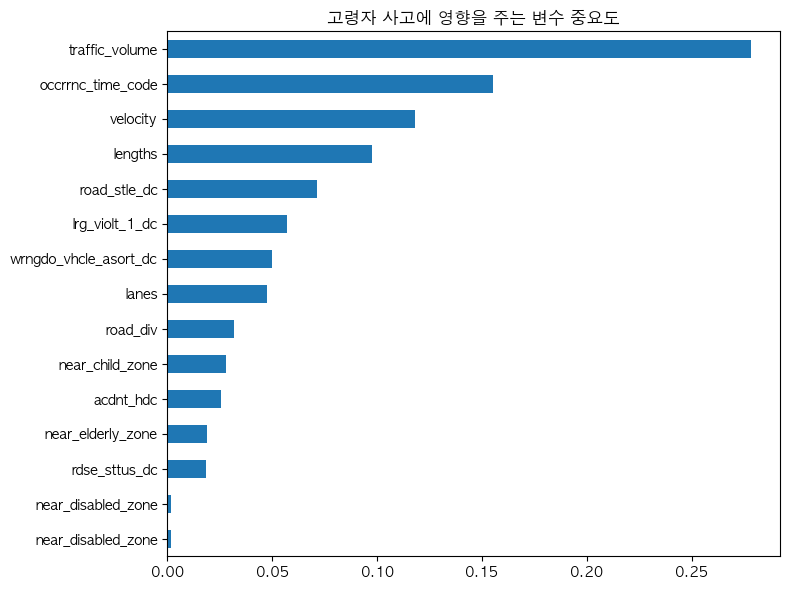

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import PartialDependenceDisplay
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# macOS일 경우 기본 애플 시스템 폰트
plt.rcParams['font.family'] = 'AppleGothic'

# 혹시 마이너스 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False
# 데이터 로드
df = pd.read_csv('./data/processed/accident_data_clesaned.csv')
# 타겟 변수
df["is_elderly_accident"] = df["acdnt_age_1_code"].apply(lambda x: 1 if x >= 65 else 0)
y = df["is_elderly_accident"]
s
# 독립변수 설정
features = [
    'occrrnc_time_code', 'acdnt_hdc', 'lrg_violt_1_dc', 'road_stle_dc',
    'wrngdo_vhcle_asort_dc', 'rdse_sttus_dc', 'road_div',
    'near_disabled_zone', 'near_child_zone', 'near_elderly_zone', 'near_disabled_zone',
    'lanes', 'lengths', 'velocity', 'traffic_volume'
]
X = df[features].copy()

# 범주형 라벨 인코딩
label_cols = X.select_dtypes(include='object').columns
for col in label_cols:
    X[col] = X[col].astype(str)  # 문자열로 통일
    X[col] = LabelEncoder().fit_transform(X[col])

# 학습 분리
X_train, X_test, y_train, y_test = train_test_split(sX, y, test_size=0.2, random_state=42)
# 모델 학습
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
#예측
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(classification_report(y_train, model.predict(X_train)))

# 변수 중요도 시각화
importances = model.feature_importances_
pd.Series(importances, index=features).sort_values().plot(kind='barh', figsize=(8, 6))
plt.title('고령자 사고에 영향을 주는 변수 중요도')
plt.tight_layout()
plt.show()
#교통량, 사고 시간대가 가장 큰 영향을 미친다.
#평균 속도, 가해 차량종류, 도로 길이도 형향을 미친다. => 테스트 

In [270]:

# 데이터 분할 (학습/테스트용 분리)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE :", pd.Series(y_train_resampled).value_counts().to_dict())

# 모델 학습
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# 테스트셋 평가
y_pred = model.predict(X_test)
print("\n📊 SMOTE 적용 후 테스트셋 성능:")
print(classification_report(y_test, y_pred))

Before SMOTE: {0: 60274, 1: 13784}
After SMOTE : {1: 60274, 0: 60274}

📊 SMOTE 적용 후 테스트셋 성능:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     15073
           1       0.23      0.24      0.23      3442

    accuracy                           0.71     18515
   macro avg       0.52      0.53      0.53     18515
weighted avg       0.71      0.71      0.71     18515



In [271]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# 모델 정의
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Stratified K-Fold (클래스 비율 유지)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# F1-score 기준으로 평가 (고령자 사고 예측 정확성 중심)
scores = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(f1_score))

print("각 Fold의 F1-score:", scores)
print("평균 F1-score:", scores.mean())
#고령자사고가 전체사고 중 소수 -> 모델이 대부분 0 으로 예측

각 Fold의 F1-score: [0.0875     0.08718563 0.08708134 0.07681229 0.08593937]
평균 F1-score: 0.08490372468508181


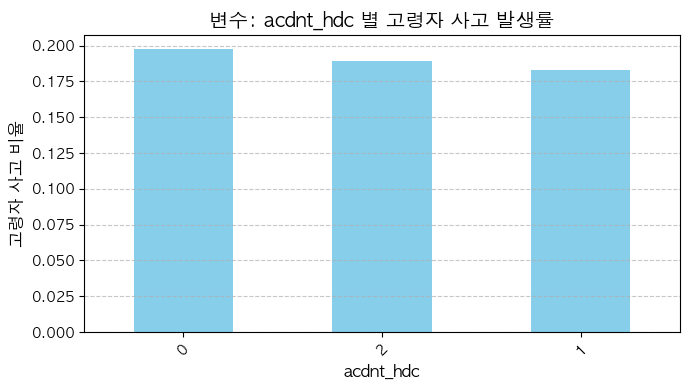

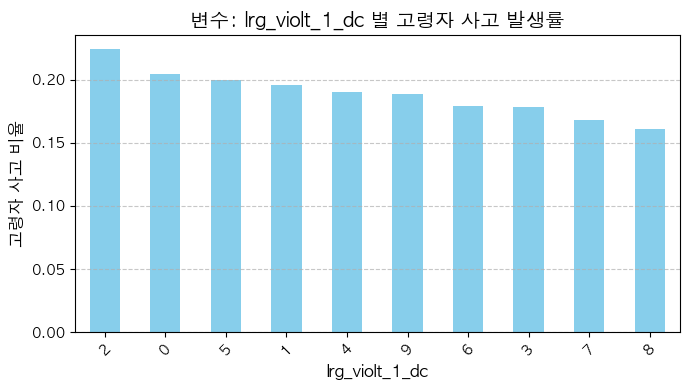

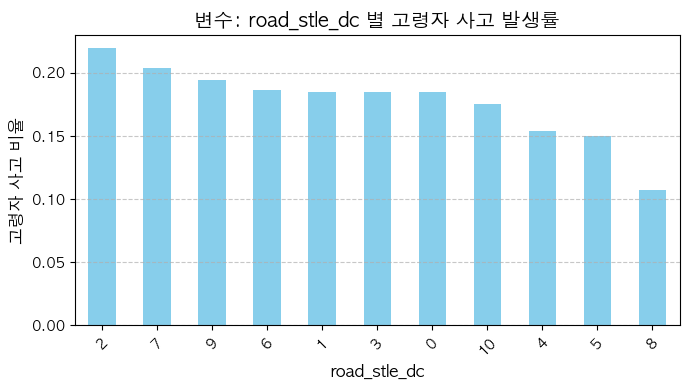

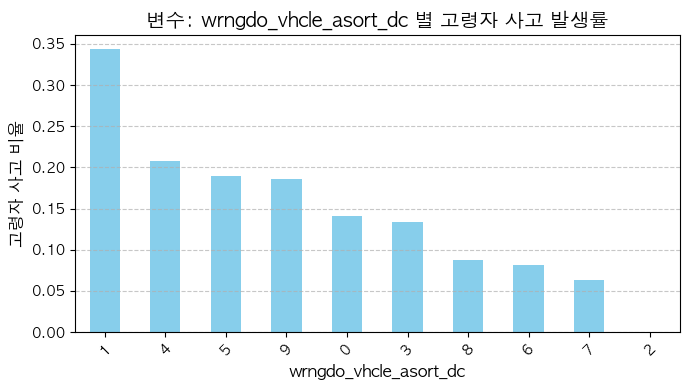

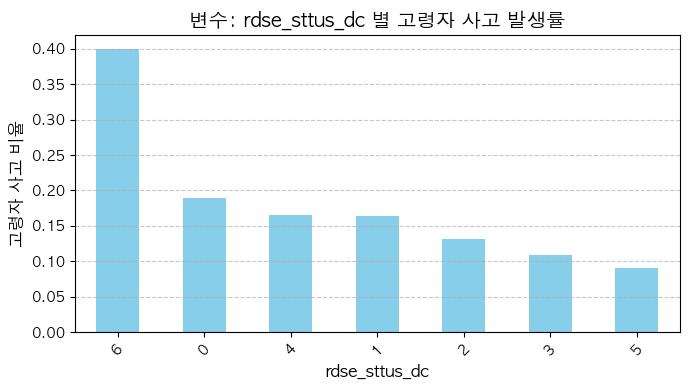

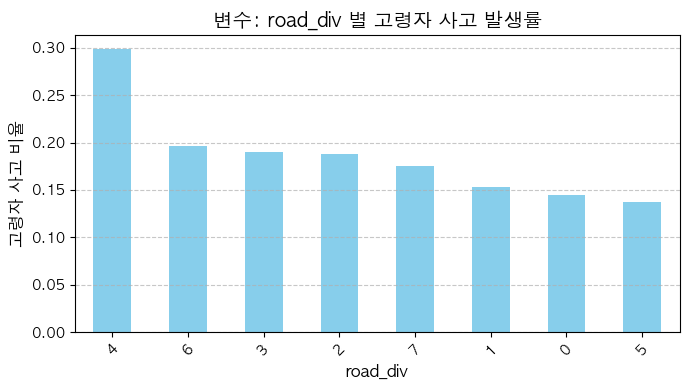

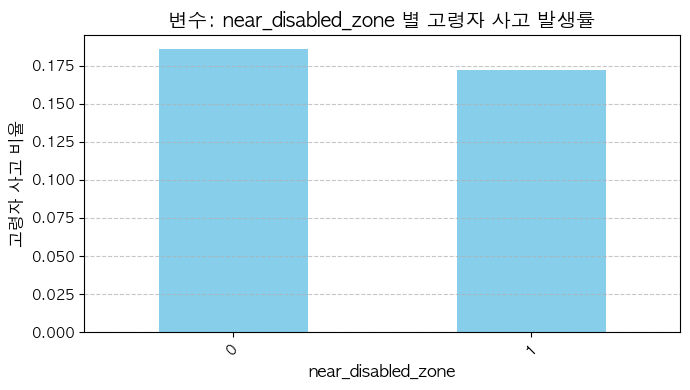

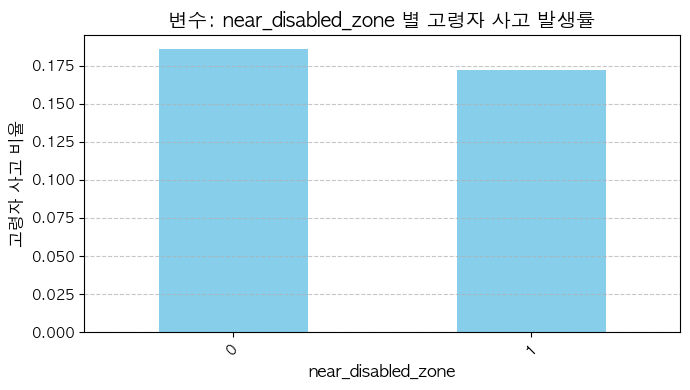

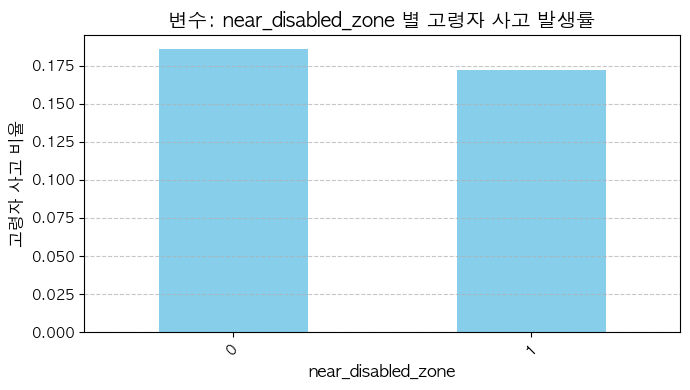

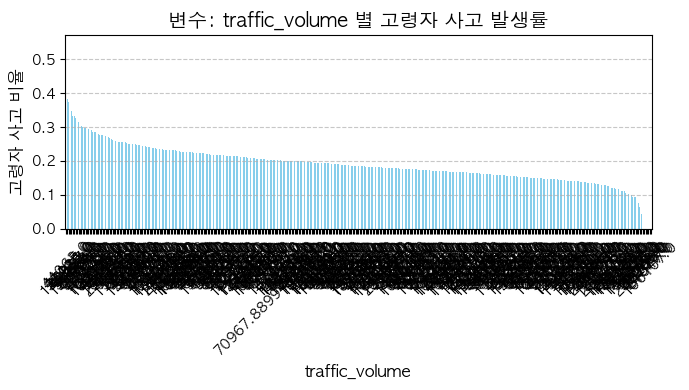

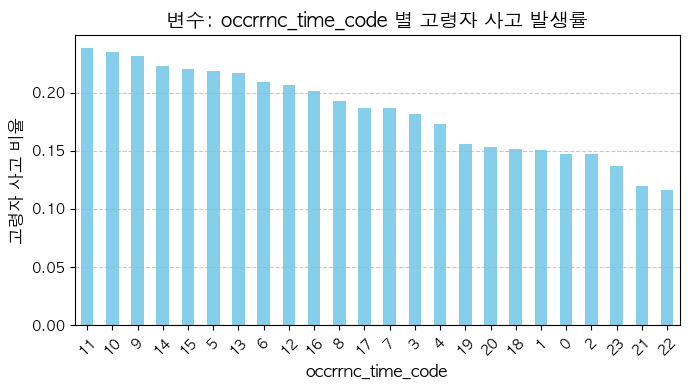

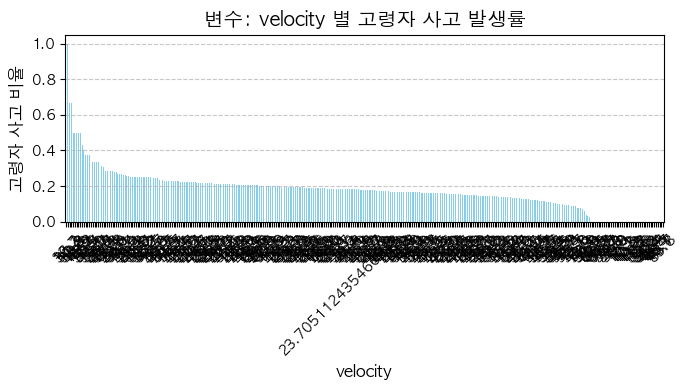

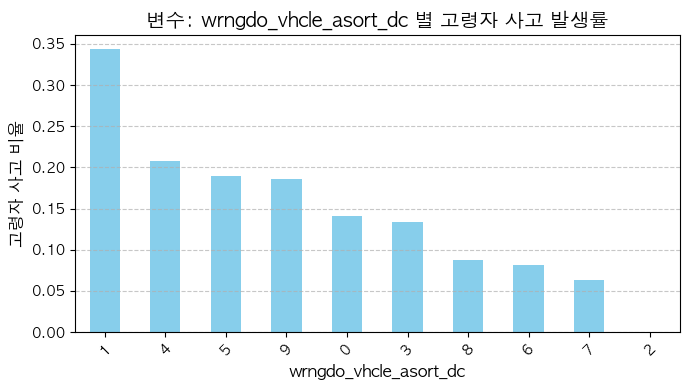

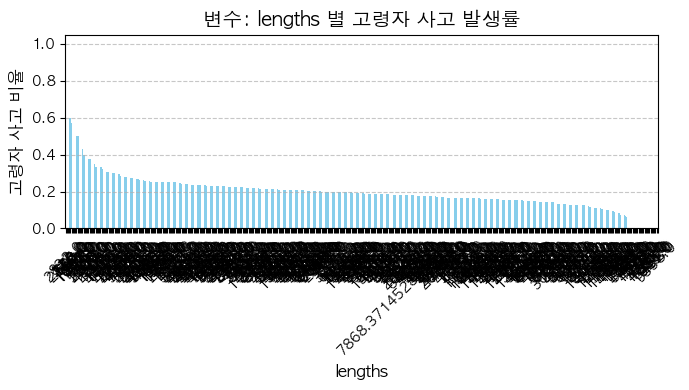

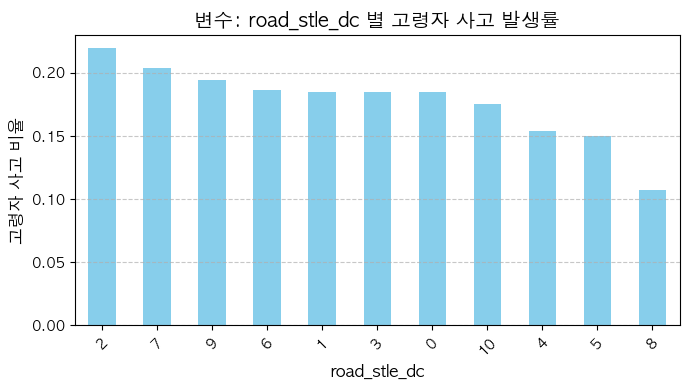

In [147]:

# 1. 데이터 불러오기
df = pd.read_csv('./data/processed/accident_data_cleaned.csv')  # 파일 경로 확인 필요

# 2. 고령자 사고 여부 컬럼 생성
df["acdnt_age_1_code"] = pd.to_numeric(df["acdnt_age_1_code"], errors="coerce")
df = df[df["acdnt_age_1_code"].notna()]
df["is_elderly_accident"] = df["acdnt_age_1_code"].apply(lambda x: 1 if x >= 65 else 0)

# 3. 분석할 범주형 변수 리스트
feature_list = [
    'acdnt_hdc',                 # 사고 유형
    'lrg_violt_1_dc',            # 법규 위반
    'road_stle_dc',              # 도로 형태
    'wrngdo_vhcle_asort_dc',     # 가해 차량 종류
    'rdse_sttus_dc',             # 노면 상태
    'road_div',                  # 도로 구분
    'near_disabled_zone',        # 장애인 보호구역 여부
    'near_disabled_zone',        # 장애인 보호구역 여부
    'near_disabled_zone',        # 장애인 보호구역 여부
    'traffic_volume',            # 교통량       
    'occrrnc_time_code',         # 사고 시간대  
    'velocity',                  # 차량속도  
    'wrngdo_vhcle_asort_dc',     # 가해 차량 종류  
    'lengths',                   # 사고 도로 길이  
    'road_stle_dc',              # 도로 형태  
]

# 4. 변수별 고령자 사고 발생률 시각화
for col in feature_list:
    plt.figure(figsize=(7, 4))
    
    # 각 값에 대해 고령자 사고율 평균 계산
    elderly_rate = df.groupby(col)["is_elderly_accident"].mean().sort_values(ascending=False)
    
    # 그래프 출력
    elderly_rate.plot(kind='bar', color='skyblue')
    plt.title(f"변수: {col} 별 고령자 사고 발생률", fontsize=14)
    plt.ylabel("고령자 사고 비율", fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

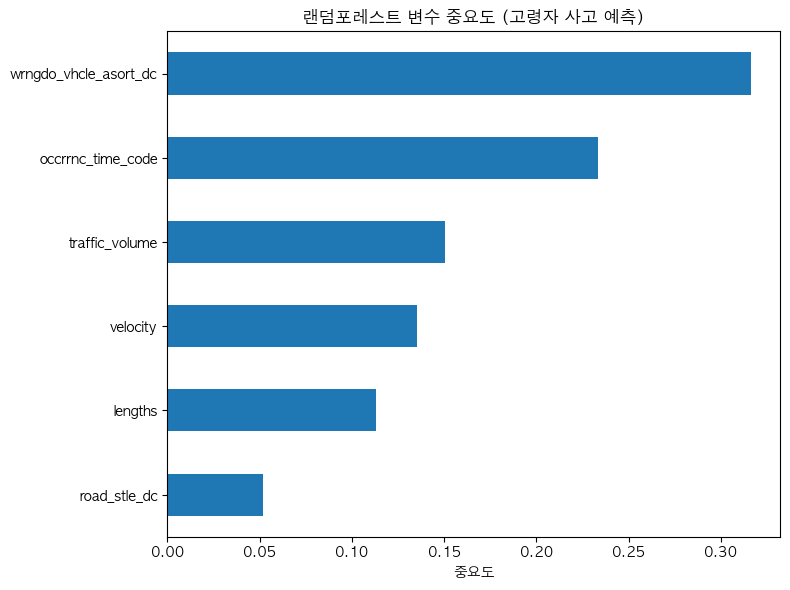

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.54      0.66     15073
           1       0.23      0.62      0.34      3442

    accuracy                           0.55     18515
   macro avg       0.55      0.58      0.50     18515
weighted avg       0.74      0.55      0.60     18515

              precision    recall  f1-score   support

           0       0.90      0.55      0.68     60274
           1       0.27      0.72      0.39     13784

    accuracy                           0.58     74058
   macro avg       0.58      0.64      0.54     74058
weighted avg       0.78      0.58      0.63     74058

Confusion Matrix:
[[8081 6992]
 [1323 2119]]
[[33030 27244]
 [ 3828  9956]]


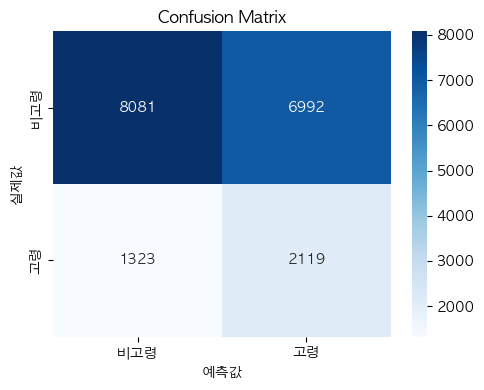

In [148]:
# 파일 경로
data_path = "./data/processed/accident_data_cleaned.csv"

# 데이터 불러오기
df = pd.read_csv(data_path)

# 고령자 사고 여부 생성
df["acdnt_age_1_code"] = pd.to_numeric(df["acdnt_age_1_code"], errors="coerce")
df = df[df["acdnt_age_1_code"].notna()]
df["is_elderly_accident"] = df["acdnt_age_1_code"].apply(lambda x: 1 if x >= 65 else 0)

# 변수 설정 (상위 6개)
selected_features = [
    'traffic_volume',
    'occrrnc_time_code',
    'velocity',
    'wrngdo_vhcle_asort_dc',
    'lengths',
    'road_stle_dc'
]
X = df[selected_features].copy()
y = df["is_elderly_accident"]

# 인코딩
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])
X = X.fillna(X.mean())

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# 변수 중요도 시각화 - 바로 출력
importances = pd.Series(model.feature_importances_, index=selected_features).sort_values()
plt.figure(figsize=(8, 6))
importances.plot(kind='barh')
plt.title("랜덤포레스트 변수 중요도 (고령자 사고 예측)")
plt.xlabel("중요도")
plt.tight_layout()
plt.show()

# 예측 결과 출력
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(classification_report(y_train, model.predict(X_train)))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(confusion_matrix(y_train, model.predict(X_train)))
# 혼동 행렬 시각화 - 바로 출력
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=["비고령", "고령"], yticklabels=["비고령", "고령"])
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
#중요도상위 6개의 변수들을 놓고 다시 돌려 보았을 때, 가해 차량 종류와 사고 시간대가 가장 큰 영향을 미친다.

Partial Dependence Plot 시각화
다른변수 고정 후 하나의 변수가 바뀌었을 때 예측값 보여주느 그래프
랜덤포레스트 설명력 확보

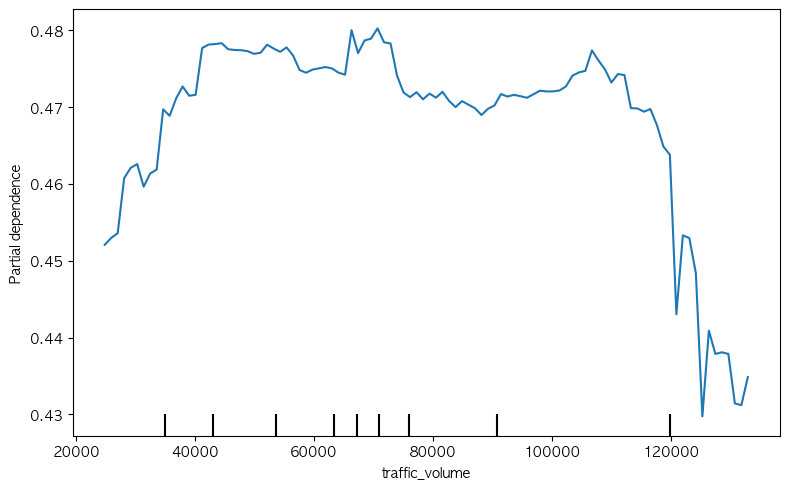

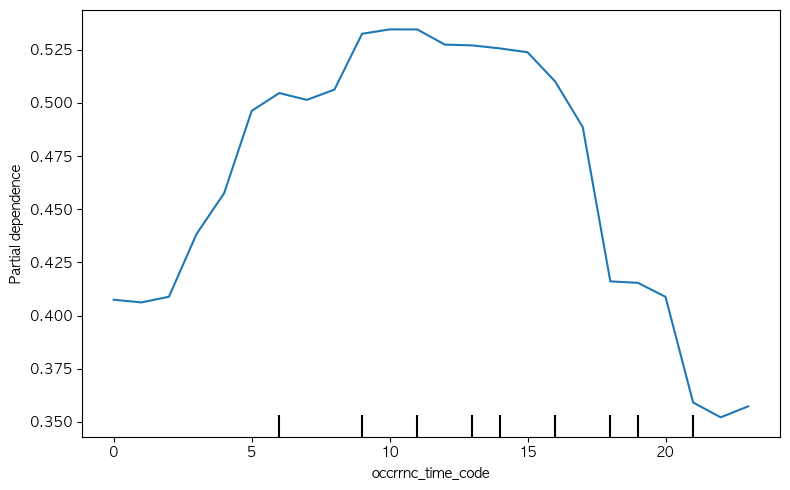

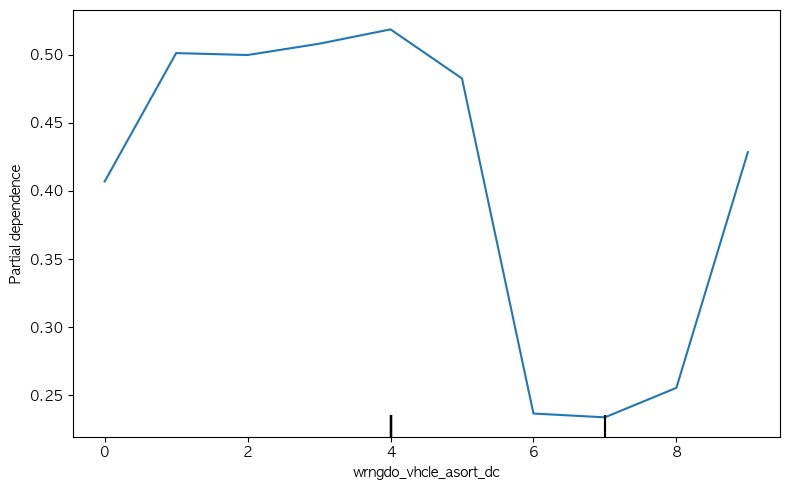

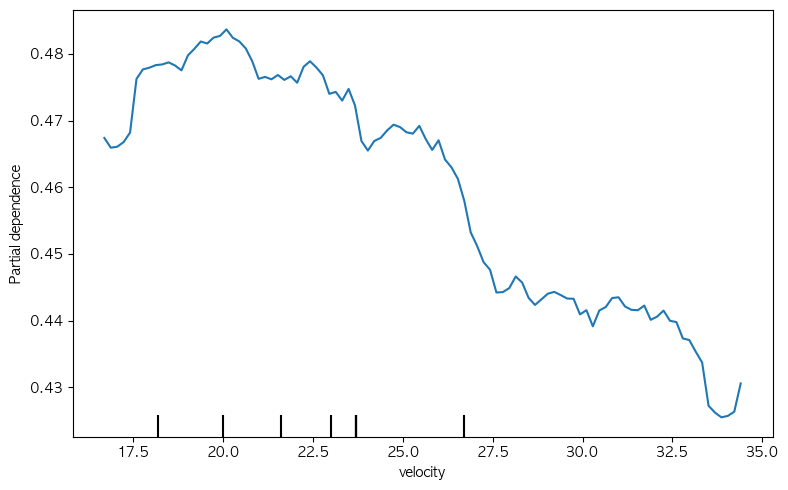

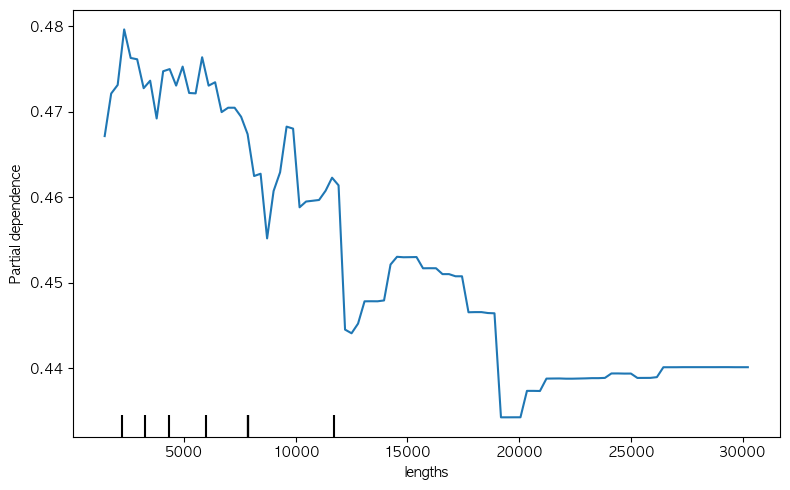

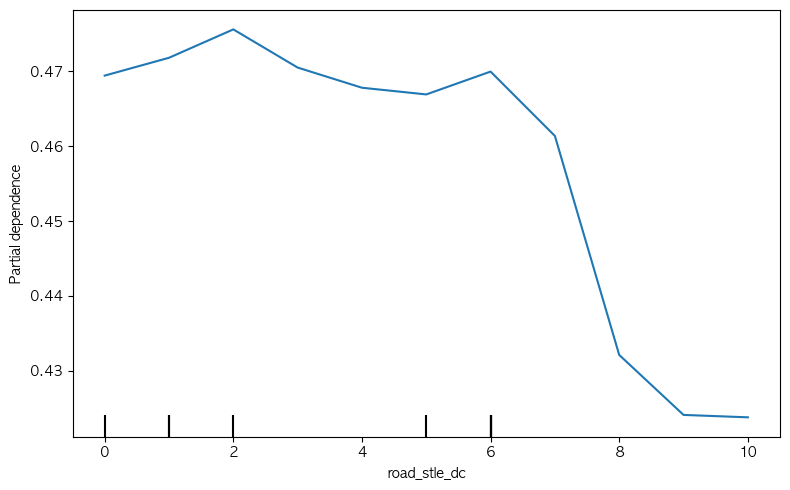

In [149]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Partial Dependence Plot 시각화
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(model, X_train, ['traffic_volume'], ax=ax)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(model, X_train, ['occrrnc_time_code'], ax=ax)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(model, X_train, ['wrngdo_vhcle_asort_dc'], ax=ax)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(model, X_train, ['velocity'], ax=ax)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(model, X_train, ['lengths'], ax=ax)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(model, X_train, ['road_stle_dc'], ax=ax)
plt.tight_layout()
plt.show()





교툥량이 중간 정보일때 (약 6만~8만)고령자 사고 확률이 가장 높고 너무 많거나 적으면 사고확률은 낮아진다
중간 밀고에서 사고 위험이 상대적으로 높아진다
특정 시간대 (오전 10시~오후2시) 사고 확률이 상승 , 일부 늦은 시간대(야간)에는 사고 예측 확률 급감
고령자들은 주가 ㄴ활동 위주이기 때문에 낮 시간대에 집중되는 경향이 있다.
특정 차량 유형에서 고령자 사고 예측 확률이 확연히 높음 
이는 이륜차, 승합차, 화물차 등에서 두드러지게 나타남 
평균속도가 낮을수록 사고 확률 낮아짐. 중간 속도인 30~5-km/h에서 사고 확률이 높아짐
느린 속도는 사고 자체가 적고, 빠른 속도는 고령자와 마주칠 가능성지 적다. 중간 속도에서 보행자와 충돌위험이 있다.
짧은 도로 구간에서 사고 확률이 더 높음. 짧은 도로일 수록 교차로, 골목, 출입구가 많고 보행자와의 접촉 가능성이 높은 환경일 수 있다.
도로 형태에 따라 예측 확률이 다름다. 예를 들어 교차로, 비신호 장애인 보호구역 구간일수록 사고 예측 확률이 높음


[근접 장애인 보호구역 여부에 따른 평균값 비교 - 고령 가해자]
                    velocity  lengths  traffic_volume
near_disabled_zone                                   
0                      23.47  7605.53        70062.52
1                      24.01  9153.91        81146.10

[road_div 비율 (%)]
road_div              0    1    2     3    4    5    6     7
near_disabled_zone                                          
0                   0.0  5.0  9.0  73.0  0.0  0.0  1.0  12.0
1                   2.0  4.0  2.0  84.0  1.0  0.0  0.0   7.0

[rdse_sttus_dc 비율 (%)]
rdse_sttus_dc          0    1    2    3    4    5    6
near_disabled_zone                                    
0                   91.0  2.0  0.0  0.0  7.0  0.0  0.0
1                   92.0  2.0  1.0  0.0  5.0  0.0  0.0


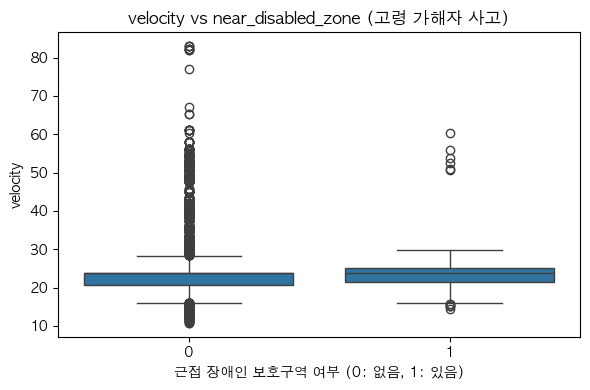

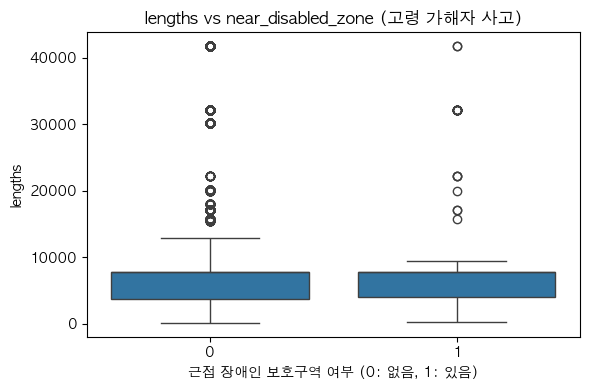

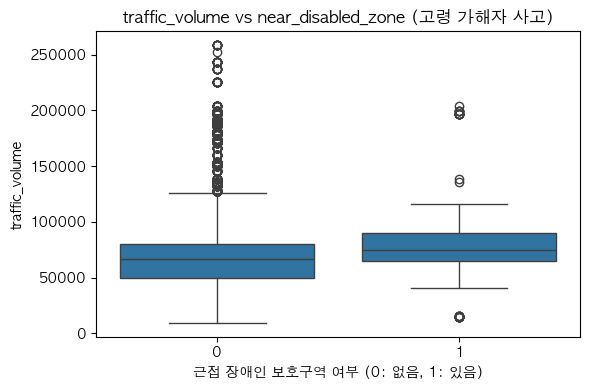

In [150]:
# 도로 환경 요약 (근접 장애인 보호구역 중심)
print("\n[근접 장애인 보호구역 여부에 따른 평균값 비교 - 고령 가해자]")
print(df_elderly_driver.groupby('near_disabled_zone')[['velocity', 'lengths', 'traffic_volume']].mean().round(2))

for col in ['road_div', 'rdse_sttus_dc']:
    print(f"\n[{col} 비율 (%)]")
    print(pd.crosstab(df_elderly_driver['near_disabled_zone'], df_elderly_driver[col], normalize='index').round(2) * 100)

#  9. 박스플롯 시각화
for col in ['velocity', 'lengths', 'traffic_volume']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_elderly_driver, x='near_disabled_zone', y=col)
    plt.title(f"{col} vs near_disabled_zone (고령 가해자 사고)")
    plt.xlabel("근접 장애인 보호구역 여부 (0: 없음, 1: 있음)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()
#횡단보도 있는 구간은 차량 속도도 낮고 도로도 더 짧고, 교통량도 적다.
# 보행자 보호 환경, 복잡한 도로 구간에서 사고가 더 많이 발생하는 경향이 있다.
#고령자 입장에서 더 위험할 수 있는 구조이다.


[근접 장애인 보호구역 여부에 따른 평균값 비교 - 고령 가해자]
                    velocity  lengths  traffic_volume
near_disabled_zone                                   
0                      23.47  7605.53        70062.52
1                      24.01  9153.91        81146.10

[road_div 비율 (%)]
road_div              0    1    2     3    4    5    6     7
near_disabled_zone                                          
0                   0.0  5.0  9.0  73.0  0.0  0.0  1.0  12.0
1                   2.0  4.0  2.0  84.0  1.0  0.0  0.0   7.0

[rdse_sttus_dc 비율 (%)]
rdse_sttus_dc          0    1    2    3    4    5    6
near_disabled_zone                                    
0                   91.0  2.0  0.0  0.0  7.0  0.0  0.0
1                   92.0  2.0  1.0  0.0  5.0  0.0  0.0


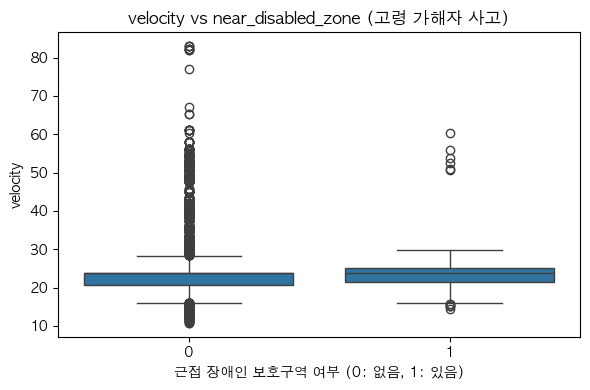

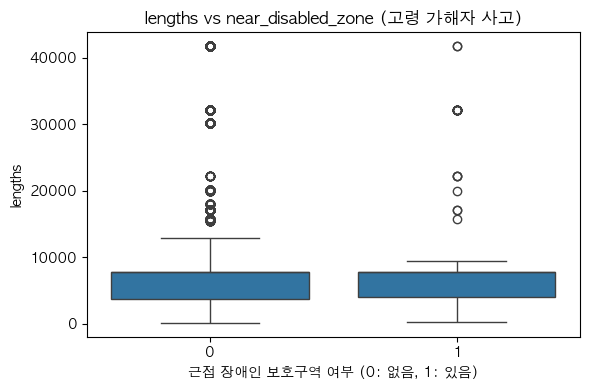

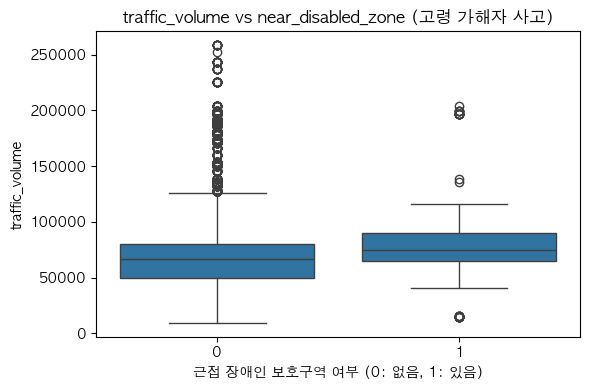

In [151]:
# 도로 환경 요약 (근접 장애인 보호구역 중심)
print("\n[근접 장애인 보호구역 여부에 따른 평균값 비교 - 고령 가해자]")
print(df_elderly_driver.groupby('near_disabled_zone')[['velocity', 'lengths', 'traffic_volume']].mean().round(2))

for col in ['road_div', 'rdse_sttus_dc']:
    print(f"\n[{col} 비율 (%)]")
    print(pd.crosstab(df_elderly_driver['near_disabled_zone'], df_elderly_driver[col], normalize='index').round(2) * 100)

#  9. 박스플롯 시각화
for col in ['velocity', 'lengths', 'traffic_volume']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_elderly_driver, x='near_disabled_zone', y=col)
    plt.title(f"{col} vs near_disabled_zone (고령 가해자 사고)")
    plt.xlabel("근접 장애인 보호구역 여부 (0: 없음, 1: 있음)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()
#장애인 보호구역 있는 구간은 평균속도 낮고, 도로길이 낮고, 차량통행량 낮아진다..
#신호제어가 있는 도심 밀집지역, 교차로 근처, 단거리 주행 구간일 가능성 높음
#고령자 입장에서 복잡하고 판단 요구 높은 환경임


[근접 장애인 보호구역 여부에 따른 평균값 비교 - 고령 가해자]
                    velocity  lengths  traffic_volume
near_disabled_zone                                   
0                      23.47  7605.53        70062.52
1                      24.01  9153.91        81146.10

[road_div 비율 (%)]
road_div              0    1    2     3    4    5    6     7
near_disabled_zone                                          
0                   0.0  5.0  9.0  73.0  0.0  0.0  1.0  12.0
1                   2.0  4.0  2.0  84.0  1.0  0.0  0.0   7.0

[rdse_sttus_dc 비율 (%)]
rdse_sttus_dc          0    1    2    3    4    5    6
near_disabled_zone                                    
0                   91.0  2.0  0.0  0.0  7.0  0.0  0.0
1                   92.0  2.0  1.0  0.0  5.0  0.0  0.0


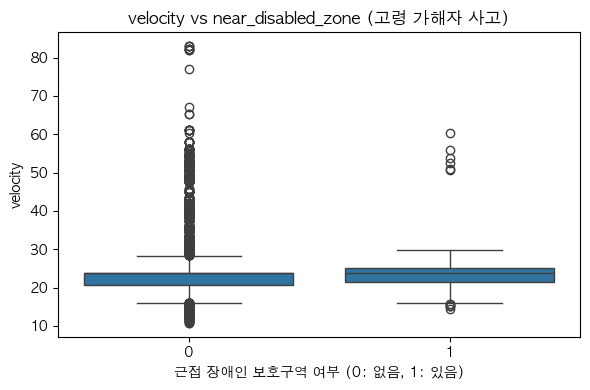

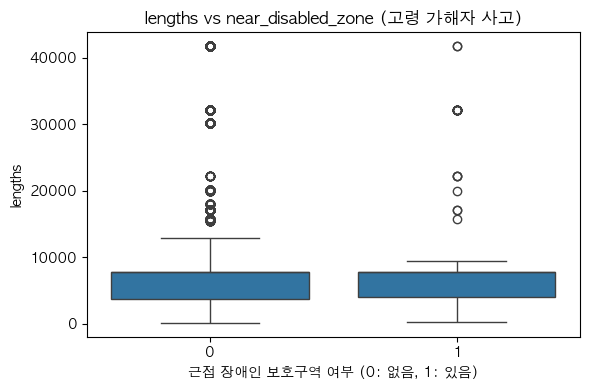

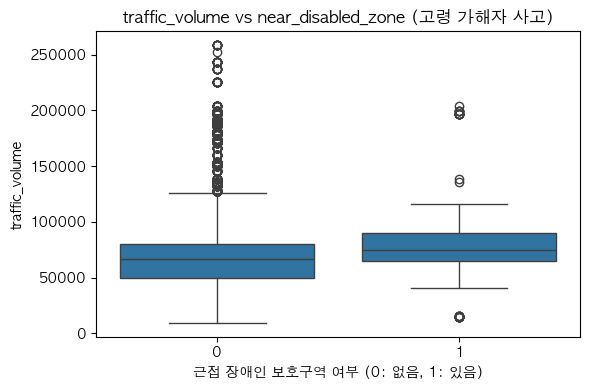

In [152]:
# 도로 환경 요약 (근접 장애인 보호구역 중심)
print("\n[근접 장애인 보호구역 여부에 따른 평균값 비교 - 고령 가해자]")
print(df_elderly_driver.groupby('near_disabled_zone')[['velocity', 'lengths', 'traffic_volume']].mean().round(2))

for col in ['road_div', 'rdse_sttus_dc']:
    print(f"\n[{col} 비율 (%)]")
    print(pd.crosstab(df_elderly_driver['near_disabled_zone'], df_elderly_driver[col], normalize='index').round(2) * 100)

#  9. 박스플롯 시각화
for col in ['velocity', 'lengths', 'traffic_volume']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_elderly_driver, x='near_disabled_zone', y=col)
    plt.title(f"{col} vs near_disabled_zone (고령 가해자 사고)")
    plt.xlabel("근접 장애인 보호구역 여부 (0: 없음, 1: 있음)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()
#장애인 보호구역 있는 구간은 속도 낮고, 도로 짧고, 통행량 낮음
#보행자 중심 지역 특성이 반영된 환경 -> 고령 운전자가 속도 감속 등 대응이 필요한 위험구간 
#장애인 보호구역은 주로 보조도로에(생활도로)에 위치 -> 보행자와의 마찰 위험 높음 
#판단 실수나 브레이크 대응 미흡으로 사고 발생 가능성 있음 


[근접 장애인 보호구역 여부에 따른 평균값 비교 - 고령 가해자]
                    velocity  lengths  traffic_volume
near_disabled_zone                                   
0                      23.47  7605.53        70062.52
1                      24.01  9153.91        81146.10

[road_div 비율 (%)]
road_div              0    1    2     3    4    5    6     7
near_disabled_zone                                          
0                   0.0  5.0  9.0  73.0  0.0  0.0  1.0  12.0
1                   2.0  4.0  2.0  84.0  1.0  0.0  0.0   7.0

[rdse_sttus_dc 비율 (%)]
rdse_sttus_dc          0    1    2    3    4    5    6
near_disabled_zone                                    
0                   91.0  2.0  0.0  0.0  7.0  0.0  0.0
1                   92.0  2.0  1.0  0.0  5.0  0.0  0.0


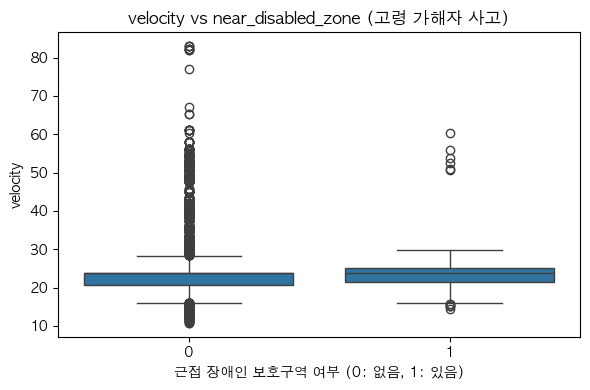

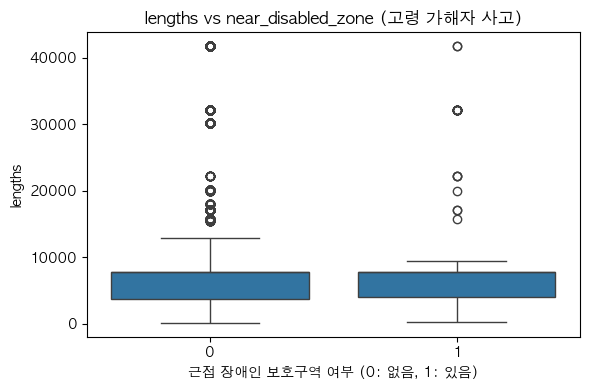

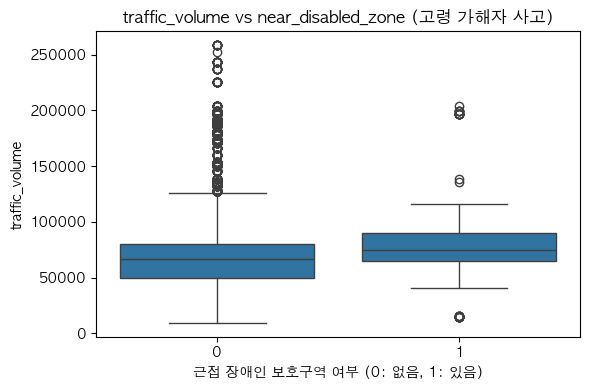

In [203]:
# 도로 환경 요약 (근접 장애인 보호구역 중심)
print("\n[근접 장애인 보호구역 여부에 따른 평균값 비교 - 고령 가해자]")
print(df_elderly_driver.groupby('near_disabled_zone')[['velocity', 'lengths', 'traffic_volume']].mean().round(2))

for col in ['road_div', 'rdse_sttus_dc']:
    print(f"\n[{col} 비율 (%)]")
    print(pd.crosstab(df_elderly_driver['near_disabled_zone'], df_elderly_driver[col], normalize='index').round(2) * 100)

#  9. 박스플롯 시각화
for col in ['velocity', 'lengths', 'traffic_volume']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_elderly_driver, x='near_disabled_zone', y=col)
    plt.title(f"{col} vs near_disabled_zone (고령 가해자 사고)")
    plt.xlabel("근접 장애인 보호구역 여부 (0: 없음, 1: 있음)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()
#장애인 보호구역 있는 구간은 속도 낮고, 도로 짧고, 통행량 낮음
#보행자 중심 지역 특성이 반영된 환경 -> 고령 운전자가 속도 감속 등 대응이 필요한 위험구간 
#장애인 보호구역은 주로 보조도로에(생활도로)에 위치 -> 보행자와의 마찰 위험 높음 
#판단 실수나 브레이크 대응 미흡으로 사고 발생 가능성 있음 


[근접 장애인 보호구역 여부에 따른 평균값 비교 - 고령 가해자]
                    velocity  lengths  traffic_volume
near_disabled_zone                                   
0                      23.47  7605.53        70062.52
1                      24.01  9153.91        81146.10

[road_div 비율 (%)]
road_div              0    1    2     3    4    5    6     7
near_disabled_zone                                          
0                   0.0  5.0  9.0  73.0  0.0  0.0  1.0  12.0
1                   2.0  4.0  2.0  84.0  1.0  0.0  0.0   7.0

[rdse_sttus_dc 비율 (%)]
rdse_sttus_dc          0    1    2    3    4    5    6
near_disabled_zone                                    
0                   91.0  2.0  0.0  0.0  7.0  0.0  0.0
1                   92.0  2.0  1.0  0.0  5.0  0.0  0.0


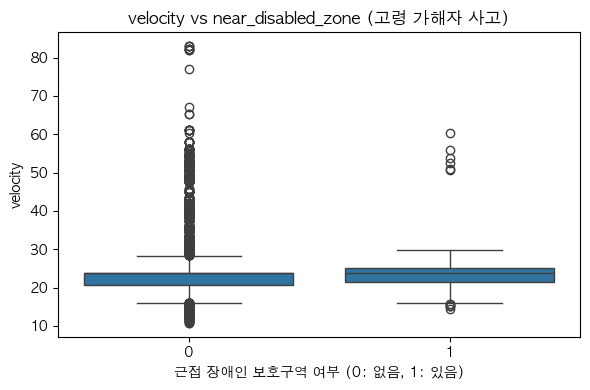

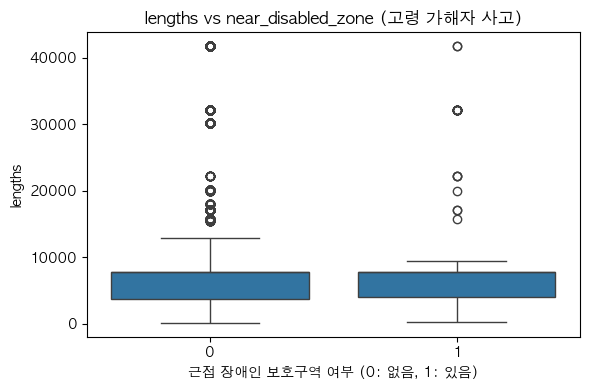

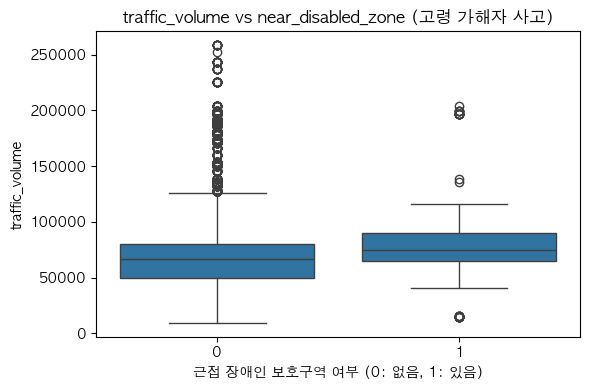

In [154]:
# 도로 환경 요약 (근접 장애인 보호구역 중심)
print("\n[근접 장애인 보호구역 여부에 따른 평균값 비교 - 고령 가해자]")
print(df_elderly_driver.groupby('near_disabled_zone')[['velocity', 'lengths', 'traffic_volume']].mean().round(2))

for col in ['road_div', 'rdse_sttus_dc']:
    print(f"\n[{col} 비율 (%)]")
    print(pd.crosstab(df_elderly_driver['near_disabled_zone'], df_elderly_driver[col], normalize='index').round(2) * 100)

#  9. 박스플롯 시각화
for col in ['velocity', 'lengths', 'traffic_volume']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_elderly_driver, x='near_disabled_zone', y=col)
    plt.title(f"{col} vs near_disabled_zone (고령 가해자 사고)")
    plt.xlabel("근접 장애인 보호구역 여부 (0: 없음, 1: 있음)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()
#장애인 보호구역 있는 구간은 속도, 도로 길이, 통행량이 모두 높게 나왔다. 또한 주도로 비율이 높다.
#다른 보호구역과 달리 장애인 보호 구역이 대규모 공공시설 근처의 간선도로, 병원/복지기관 . 앞대로변에 설치 될 가능성 보여줌
#보호구역임에도 불구하고 물리적 교통 환경이 고령자에게 위험할 수 있는 구조임 

📌 [Test Set]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78     15073
           1       0.19      0.25      0.22      3442

    accuracy                           0.66     18515
   macro avg       0.50      0.50      0.50     18515
weighted avg       0.70      0.66      0.68     18515

📌 [Train Set]
              precision    recall  f1-score   support

           0       0.93      0.81      0.86     60274
           1       0.47      0.74      0.57     13784

    accuracy                           0.79     74058
   macro avg       0.70      0.77      0.72     74058
weighted avg       0.85      0.79      0.81     74058



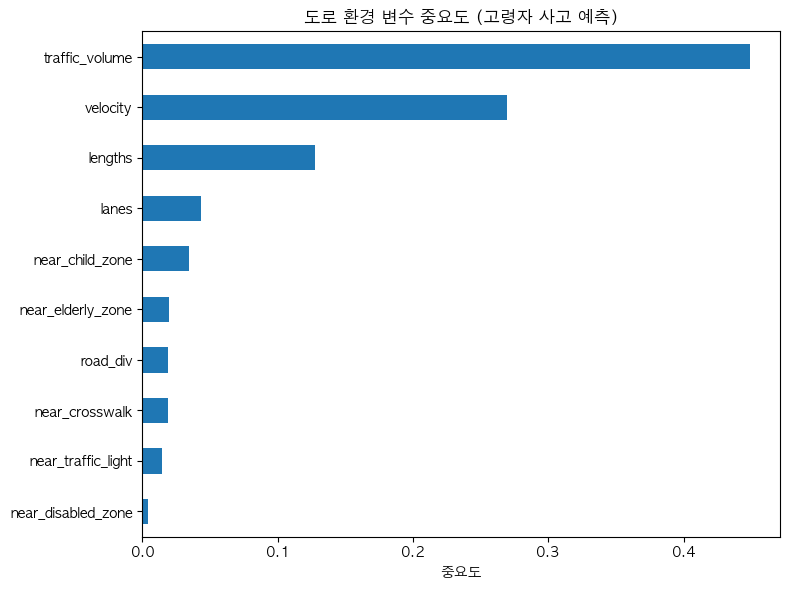

In [237]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# 1. 데이터 불러오기
df = pd.read_csv("./data/processed/accident_data_cleaned.csv")

# 2. 고령자 사고 여부 생성
df["acdnt_age_1_code"] = pd.to_numeric(df["acdnt_age_1_code"], errors="coerce")
df = df[df["acdnt_age_1_code"].notna()]
df["is_elderly_accident"] = df["acdnt_age_1_code"].apply(lambda x: 1 if x >= 65 else 0)

# 3. 변수 선택
road_features = [
    'road_div', 'lengths', 'lanes', 'velocity', 'traffic_volume',
    'near_crosswalk', 'near_traffic_light', 'near_child_zone',
    'near_elderly_zone', 'near_disabled_zone'
]

X = df[road_features].copy()
y = df["is_elderly_accident"]

# 인코딩 & 결측치 처리
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])
X = X.fillna(X.mean())

# 4. 모델 학습
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# ✅ 예측값 정의
y_pred = model.predict(X_test)

# 평가
print("📌 [Test Set]")
print(classification_report(y_test, y_pred))

print("📌 [Train Set]")
print(classification_report(y_train, model.predict(X_train)))

# 5. 변수 중요도 시각화
importances = pd.Series(model.feature_importances_, index=road_features).sort_values()
plt.figure(figsize=(8, 6))
importances.plot(kind='barh')
plt.title("도로 환경 변수 중요도 (고령자 사고 예측)")
plt.xlabel("중요도")
plt.tight_layout()
plt.show()

   도로유형  전체사고수  고령자사고수    고령자사고율  고령자사고율(%)
0     0    485      70  0.144330      14.43
1     1   5241     802  0.153024      15.30
2     2   8327    1562  0.187583      18.76
3     3  65754   12511  0.190270      19.03
4     4    184      55  0.298913      29.89
5     5    175      24  0.137143      13.71
6     6   1075     211  0.196279      19.63
7     7  11332    1991  0.175697      17.57


/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_55576/1876071687.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=road_div_stats, x="도로유형", y="고령자사고율(%)", palette="Blues_d")


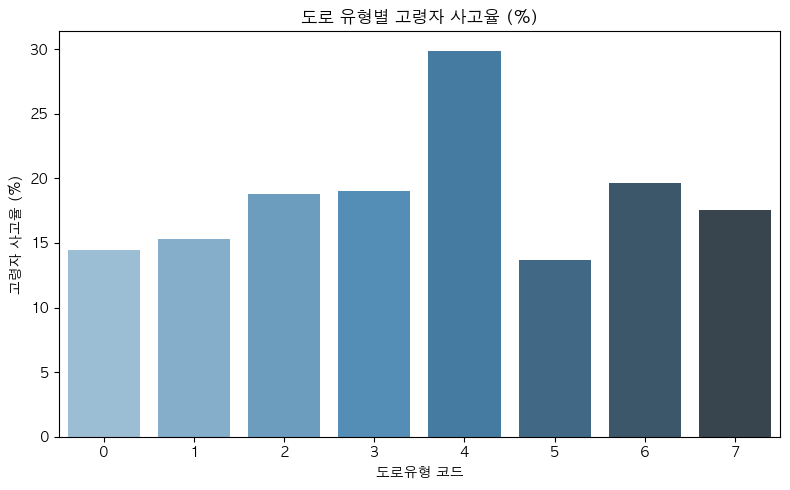

In [257]:
df["acdnt_age_1_code"] = pd.to_numeric(df["acdnt_age_1_code"], errors="coerce")
df = df[df["acdnt_age_1_code"].notna()]
df["is_elderly_accident"] = df["acdnt_age_1_code"].apply(lambda x: 1 if x >= 65 else 0)

# 도로 유형별 전체 사고 대비 고령자 사고 비율
road_div_stats = df.groupby("road_div")["is_elderly_accident"].agg(['count', 'sum', 'mean']).reset_index()
road_div_stats.columns = ["도로유형", "전체사고수", "고령자사고수", "고령자사고율"]
road_div_stats["고령자사고율(%)"] = (road_div_stats["고령자사고율"] * 100).round(2)
print(road_div_stats)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=road_div_stats, x="도로유형", y="고령자사고율(%)", palette="Blues_d")
plt.title("도로 유형별 고령자 사고율 (%)")
plt.xlabel("도로유형 코드")
plt.ylabel("고령자 사고율 (%)")
plt.tight_layout()
plt.show()

In [239]:
print(X_train.columns)

Index(['road_div', 'lengths', 'lanes', 'velocity', 'traffic_volume',
       'near_crosswalk', 'near_traffic_light', 'near_child_zone',
       'near_elderly_zone', 'near_disabled_zone'],
      dtype='object')


[Test Set]
              precision    recall  f1-score   support

           0       0.82      0.76      0.78     15070
           1       0.19      0.25      0.22      3445

    accuracy                           0.66     18515
   macro avg       0.50      0.50      0.50     18515
weighted avg       0.70      0.66      0.68     18515

Confusion Matrix:
[[11386  3684]
 [ 2569   876]]


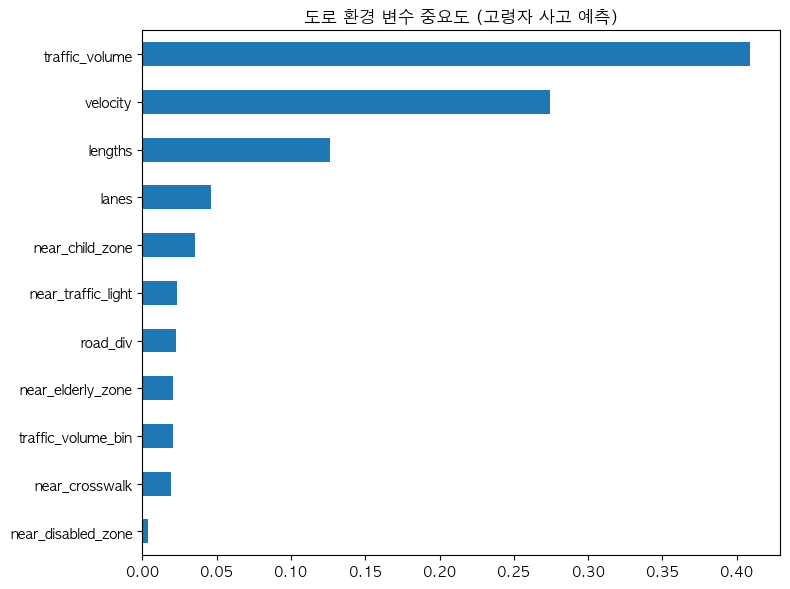

In [260]:


# 1. 데이터 불러오기
df = pd.read_csv("./data/processed/accident_data_cleaned.csv")

# 2. 고령자 사고 여부 생성
df["acdnt_age_1_code"] = pd.to_numeric(df["acdnt_age_1_code"], errors="coerce")
df = df[df["acdnt_age_1_code"].notna()]
df["is_elderly_accident"] = df["acdnt_age_1_code"].apply(lambda x: 1 if x >= 65 else 0)

# 3. 사용 변수 선택
selected_features = [
    'road_div', 'lengths', 'lanes', 'velocity', 'traffic_volume',
    'near_crosswalk', 'near_traffic_light', 'near_child_zone',
    'near_elderly_zone', 'near_disabled_zone'
]
X = df[selected_features].copy()
y = df["is_elderly_accident"]

# 4. 범주형 인코딩
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])
X = X.fillna(X.mean())

# 5. 교통량 구간화 + 인코딩
X['traffic_volume_bin'] = pd.qcut(X['traffic_volume'], q=4, labels=['낮음', '중간', '높음', '매우높음'])
X['traffic_volume_bin'] = LabelEncoder().fit_transform(X['traffic_volume_bin'])

# 6. train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 7. 랜덤포레스트 모델 학습
model = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 8. 예측 및 평가
y_pred = model.predict(X_test)
print("[Test Set]")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 9. 변수 중요도 시각화
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(8, 6))
importances.plot(kind='barh')
plt.title("도로 환경 변수 중요도 (고령자 사고 예측)")
plt.tight_layout()
plt.show()

In [252]:
print(X.columns.tolist())

['velocity', 'road_div']


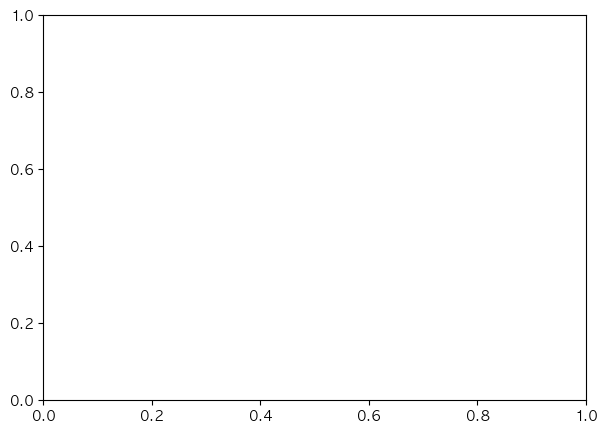

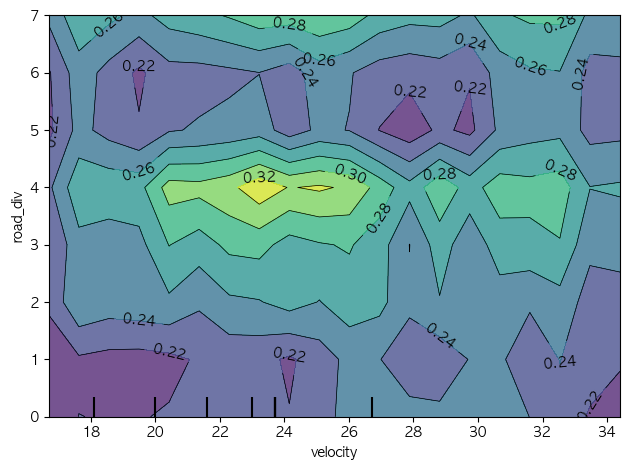

In [261]:
#도로형태별 속도 변화에 따른 위험도
fig, ax = plt.subplots(figsize=(7, 5))
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    [('velocity', 'road_div')], 
    kind='average',
    grid_resolution=20
)
plt.tight_layout()
plt.show()

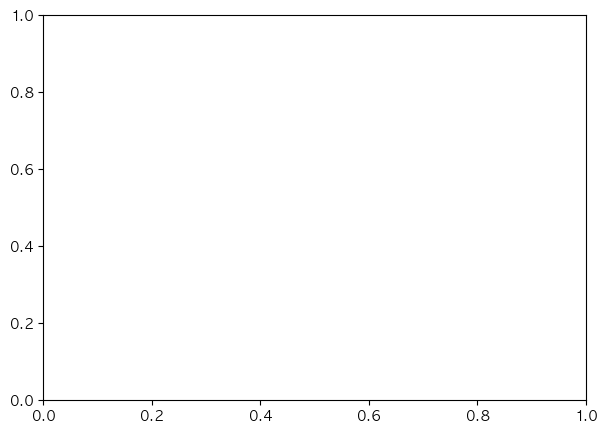

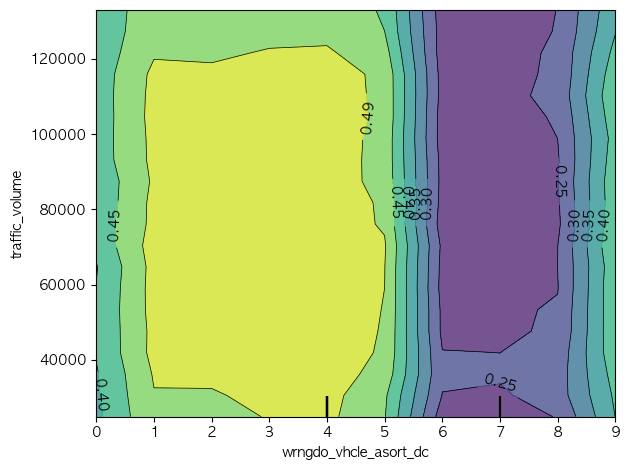

In [ ]:
#가해차량 유형별 혼잡 구간의 사고 영향 차이
fig, ax = plt.subplots(figsize=(7, 5))
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    [('wrngdo_vhcle_asort_dc', 'traffic_volume')], 
    kind='average',
    grid_resolution=20
)
plt.tight_layout()
plt.show()

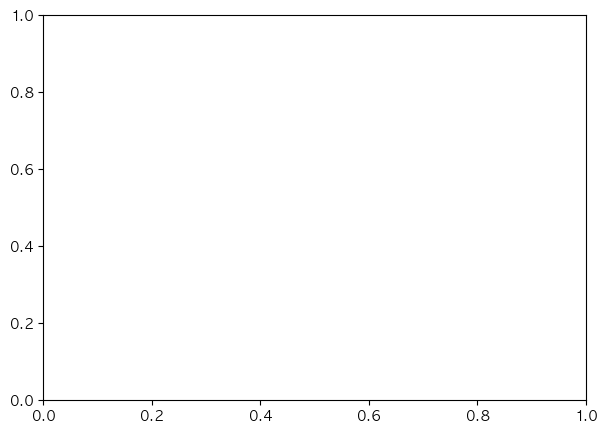

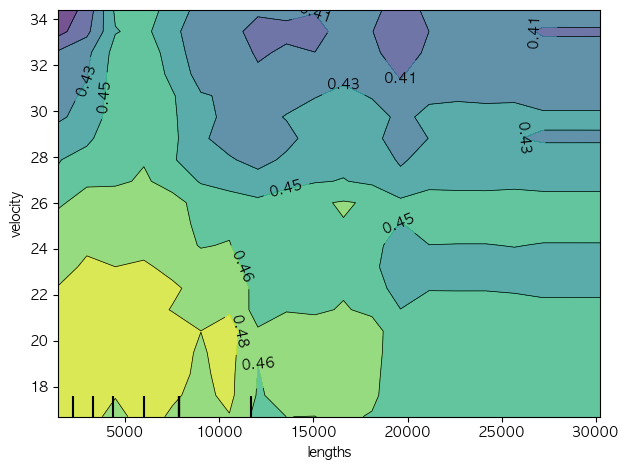

In [ ]:
#도로 길이와 속도 조합 → 장거리 고속 위험구간 여부
fig, ax = plt.subplots(figsize=(7, 5))
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    [('lengths', 'velocity')], 
    kind='average',
    grid_resolution=20
)
plt.tight_layout()
plt.show()

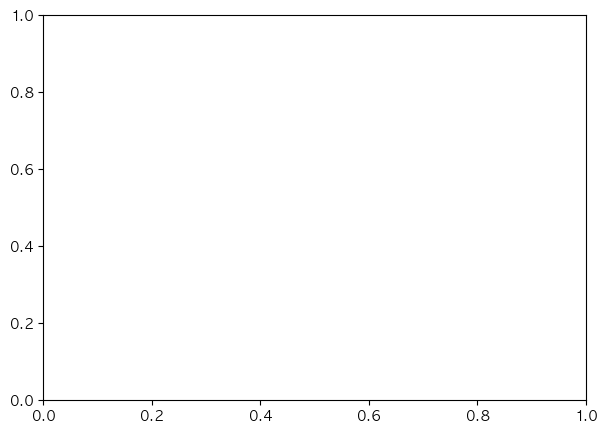

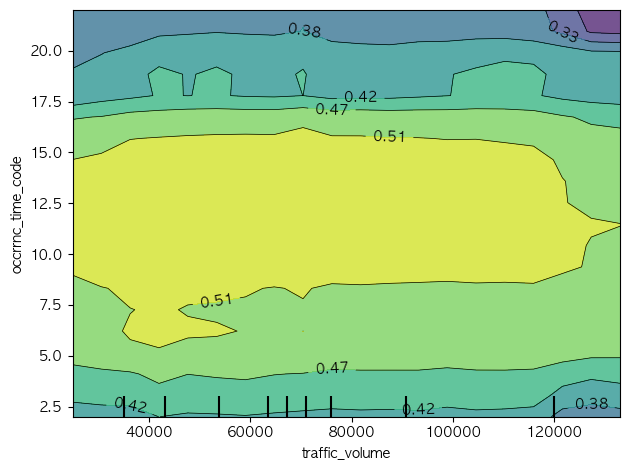

In [ ]:
#시간대별 혼잡도로 인한 사고 예측 차이
fig, ax = plt.subplots(figsize=(7, 5))
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    [('traffic_volume', 'occrrnc_time_code')], 
    kind='average',
    grid_resolution=20
)
plt.tight_layout()
plt.show()

Before SMOTE: {0: 60277, 1: 13781}
After SMOTE : {0: 60277, 1: 60277}

📊 XGBoost + SMOTE 테스트셋 성능:
              precision    recall  f1-score   support

           0       0.81      0.64      0.72     15070
           1       0.18      0.35      0.24      3445

    accuracy                           0.59     18515
   macro avg       0.50      0.49      0.48     18515
weighted avg       0.69      0.59      0.63     18515

              precision    recall  f1-score   support

           0       0.82      0.65      0.73     60277
           1       0.20      0.40      0.27     13781

    accuracy                           0.60     74058
   macro avg       0.51      0.52      0.50     74058
weighted avg       0.71      0.60      0.64     74058



/Users/leejuan/Documents/GitHub/senior-road-risk-analyzer/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:38:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


<Figure size 1000x600 with 0 Axes>

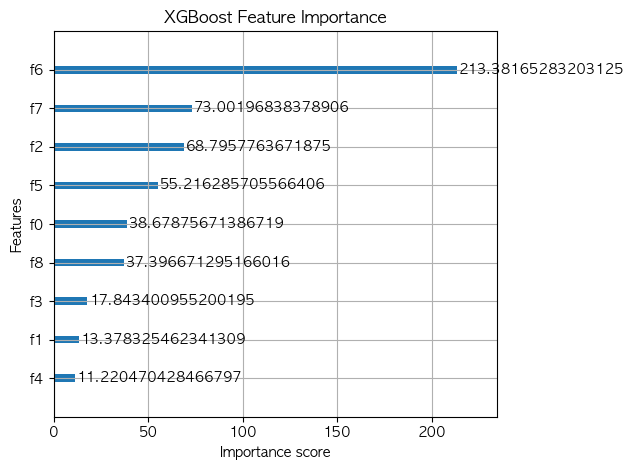

In [ ]:
# 필수 라이브러리 임포트
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
# ✅ 0. 중복 컬럼 제거 (맨 위에 딱 한 줄 추가)
X = X.loc[:, ~X.columns.duplicated()]
# 🚨 데이터 준비: X, y는 미리 전처리된 상태라고 가정
# 예: 범주형 인코딩 완료, 자전거 제외, 변수 선택 완료

# 1. 학습/테스트셋 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. SMOTE로 소수 클래스 오버샘플링
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE :", pd.Series(y_train_resampled).value_counts().to_dict())

# 3. XGBoost 모델 정의
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=1,  # SMOTE 적용했으므로 따로 안줘도 됨
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 4. 학습 (넘파이 배열로 변환해 pandas dtype 오류 방지)
xgb_model.fit(X_train_resampled.values, y_train_resampled)

# 5. 예측 및 평가 (역시 넘파이 변환)
y_pred = xgb_model.predict(X_test.values)

# 6. 성능 확인
print("\n📊 XGBoost + SMOTE 테스트셋 성능:")
print(classification_report(y_test, y_pred))
print(classification_report(y_train, xgb_model.predict(X_train.values)))
from xgboost import plot_importance  # 꼭 필요!

# 변수 중요도 시각화
import matplotlib.pyplot as plt
#시각화
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10, importance_type='gain')  # gain 기준 상위 10개
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

위 모델은 고령자사고 예측 신호등이 있는지 없는지가 가장 큰 영향을 준다고 판단함 

In [197]:
X_train.columns.tolist()

['road_div',
 'lengths',
 'lanes',
 'velocity',
 'traffic_volume',
 'near_crosswalk',
 'near_traffic_light',
 'near_child_zone',
 'near_disabled_zone']

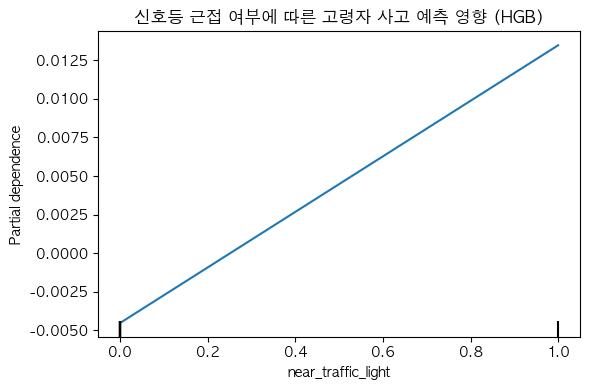

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

# XGBoost 대신 호환 잘 되는 모델로 대체 (PDP용)
model_pdp = HistGradientBoostingClassifier(random_state=42)
model_pdp.fit(X_train, y_train)

# PDP 시각화
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    model_pdp,
    X_test,
    features=['near_traffic_light'],
    kind='average',
    ax=ax
)
plt.title("신호등 근접 여부에 따른 고령자 사고 예측 영향 (HGB)")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import itertools

# 데이터 로드
df = pd.read_csv("./data/processed/accident_data_filtered.csv")
df["acdnt_age_1_code"] = pd.to_numeric(df["acdnt_age_1_code"], errors="coerce")
df = df[df["acdnt_age_1_code"].notna()]
df["is_elderly_accident"] = df["acdnt_age_1_code"].apply(lambda x: 1 if x >= 65 else 0)

# 분석할 피처 목록
features = [
    'velocity', 'lanes', 'lengths', 'traffic_volume',
    'near_crosswalk', 'near_traffic_light', 'near_child_zone',
    'near_disabled_zone', 'road_div', 'rdse_sttus_dc',
    'wrngdo_vhcle_asort_dc','road_stle_dc'
]

# 범주형 처리
for col in features:
    if df[col].dtype == 'object':
        df[col] = df[col].astype("category").cat.codes

# 이중 조합별 사고율 계산
combo_results = []
for f1, f2 in itertools.combinations(features, 2):
    temp = df[[f1, f2, 'is_elderly_accident']].copy()
    temp[f1] = pd.qcut(temp[f1], q=4, duplicates='drop', labels=False)
    temp[f2] = pd.qcut(temp[f2], q=4, duplicates='drop', labels=False)
    
    grouped = temp.groupby([f1, f2])['is_elderly_accident'].mean().reset_index()
    grouped['feature_1'] = f1
    grouped['feature_2'] = f2
    grouped.rename(columns={'is_elderly_accident': 'elderly_accident_rate'}, inplace=True)
    
    combo_results.append(grouped)

combo_df = pd.concat(combo_results, ignore_index=True)

/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_55576/292212131.py:5: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/processed/accident_data_filtered.csv")


In [ ]:
high_risk_combos = combo_df[combo_df['elderly_accident_rate'] >= 0.25]
high_risk_combos = high_risk_combos.sort_values(by='elderly_accident_rate', ascending=False)
display(high_risk_combos.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 371 to 390
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   velocity               0 non-null      float64
 1   lanes                  0 non-null      float64
 2   elderly_accident_rate  2 non-null      float64
 3   feature_1              2 non-null      object 
 4   feature_2              2 non-null      object 
 5   lengths                0 non-null      float64
 6   traffic_volume         0 non-null      float64
 7   near_crosswalk         0 non-null      float64
 8   near_traffic_light     0 non-null      float64
 9   near_child_zone        0 non-null      float64
 10  near_disabled_zone     0 non-null      float64
 11  road_div               1 non-null      float64
 12  rdse_sttus_dc          0 non-null      float64
 13  wrngdo_vhcle_asort_dc  2 non-null      float64
 14  road_stle_dc           1 non-null      float64
dtypes: float64(

None

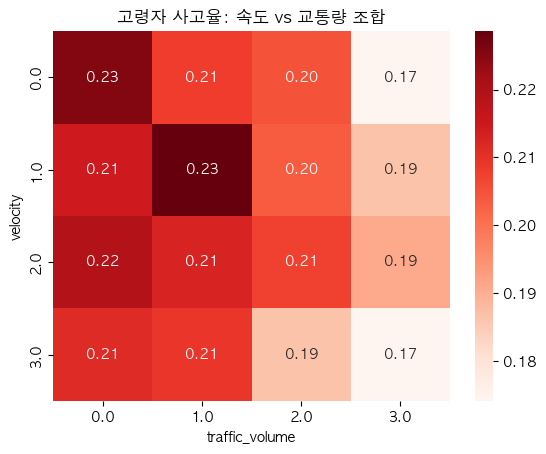

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예시: velocity x traffic_volume 조합 heatmap
pivot = combo_df[
    (combo_df['feature_1'] == 'velocity') & 
    (combo_df['feature_2'] == 'traffic_volume')
].pivot(index='velocity', columns='traffic_volume', values='elderly_accident_rate')

sns.heatmap(pivot, annot=True, cmap="Reds", fmt=".2f")
plt.title("고령자 사고율: 속도 vs 교통량 조합")
plt.show()
#느린 속도 + 저/중 교통량 구간에서 고령자 사고율이 가장높음

/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_55576/3516412243.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/processed/accident_data_filtered.csv")
/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_55576/3516412243.py:27: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/leejuan/Documents/GitHub/senior-road-risk-analyzer/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


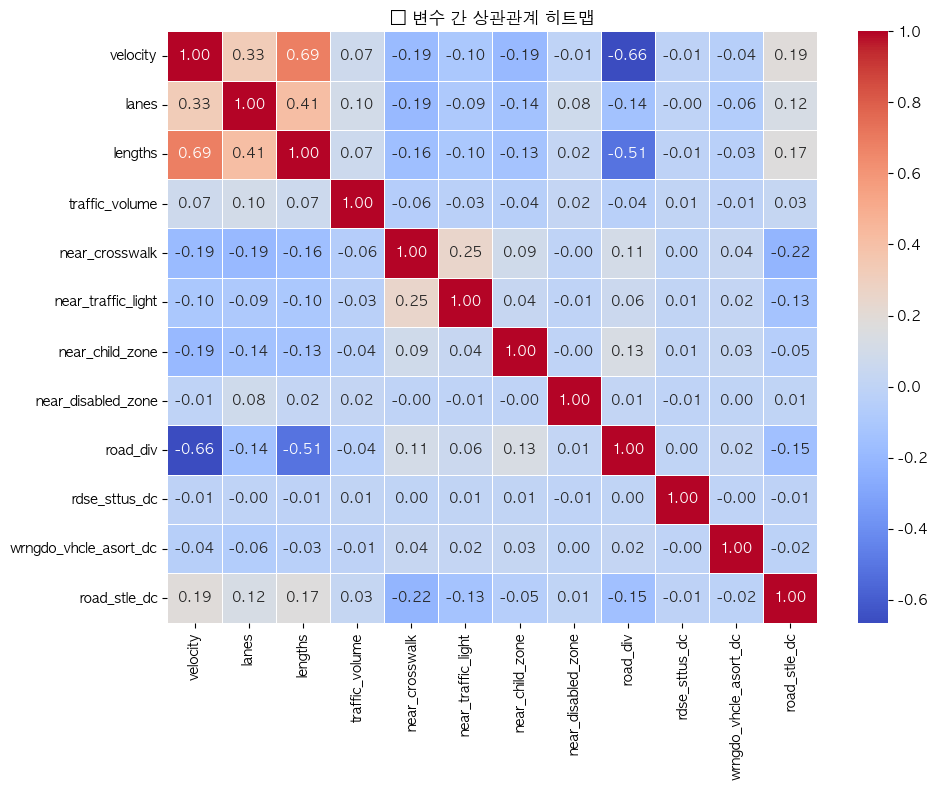

In [ ]:
# 데이터 로드
df = pd.read_csv("./data/processed/accident_data_filtered.csv")

# 수치형 변수만 추출 (필요시 범주형도 숫자로 변환)
cols = [
   'velocity', 'lanes', 'lengths', 'traffic_volume',
    'near_crosswalk', 'near_traffic_light', 'near_child_zone',
    'near_disabled_zone', 'road_div', 'rdse_sttus_dc',
    'wrngdo_vhcle_asort_dc','road_stle_dc'
]

# 범주형 숫자화
for col in cols:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

# 결측치 처리
df = df[cols].dropna()

# 상관계수 계산
corr = df.corr(method='pearson')

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("🚦 변수 간 상관관계 히트맵")
plt.tight_layout()
plt.show()

In [264]:
selected_features = [
    'road_div', 'lengths', 'lanes', 'velocity', 'traffic_volume',
    'near_crosswalk', 'near_traffic_light', 'near_child_zone',
    'near_elderly_zone', 'near_disabled_zone'
]

최종예측모델 ? 

In [265]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 1. Load data
df = pd.read_csv("./data/processed/accident_data_cleaned.csv")

# 2. 타겟 변수 생성
df["acdnt_age_1_code"] = pd.to_numeric(df["acdnt_age_1_code"], errors="coerce")
df = df[df["acdnt_age_1_code"].notna()]
df["is_elderly_accident"] = df["acdnt_age_1_code"].apply(lambda x: 1 if x >= 65 else 0)

# 3. 변수 선택
X = df[selected_features].copy()
y = df["is_elderly_accident"]
# 자전거 제외
df = df[df["wrngdo_vhcle_asort_dc"] != "자전거"]
# 4. 인코딩 & 결측치 처리
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])
X = X.fillna(X.mean())

# 5. train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 6. 모델 학습
model = RandomForestClassifier(n_estimators=150, max_depth=10, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 7. 예측 및 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.52      0.64     15070
           1       0.20      0.51      0.28      3445

    accuracy                           0.52     18515
   macro avg       0.51      0.52      0.46     18515
weighted avg       0.71      0.52      0.57     18515

[[7807 7263]
 [1675 1770]]


In [2]:
# traffic_volume 컬럼 결측치만 추출
missing_traffic_df = df[df['traffic_volume'].isna()]

# 확인
print(missing_traffic_df.head())
print(f"결측치 행 수: {len(missing_traffic_df)}")

NameError: name 'df' is not defined

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
os.chdir("/Users/leejuan/Documents/GitHub/senior-road-risk-analyzer")
print("✅ 작업 경로 변경 완료:", os.getcwd())
# 데이터 불러오기
df = pd.read_csv("./data/processed/accident_data_filtered.csv")
df.head()

✅ 작업 경로 변경 완료: /Users/leejuan/Documents/GitHub/senior-road-risk-analyzer


/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_72743/1929682364.py:8: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/processed/accident_data_filtered.csv")


,acdnt_year,occrrnc_time_code,legaldong_name,acdnt_hdc,lrg_violt_1_dc,road_stle_dc,wrngdo_vhcle_asort_dc,acdnt_age_1_code,rdse_sttus_dc,road_div,...,near_child_zone,near_elderly_zone,near_disabled_zone,lanes,lengths,velocity,traffic_volume,elderly_hotspot,non_elderly_hotspot,all_hotspot
0,2021,4,서울특별시 강남구 일원동,차대사람,안전운전불이행,교차로 - 교차로부근,승용,32,건조,105.0,...,1,0,1,8.0,17101.0,26.2,97512,NaN,1.0,0
1,2021,21,서울특별시 강남구 도곡동,차대차,신호위반,교차로 - 교차로안,승용,44,건조,104.0,...,0,0,0,6.0,6344.0,20.1,58894,NaN,1.0,1
2,2021,3,서울특별시 강남구 역삼동,차대차,신호위반,단일로 - 기타,승용,22,건조,104.0,...,1,0,0,6.0,8312.0,22.6,53898,NaN,1.0,1
3,2021,10,서울특별시 강남구 역삼동,차대차,안전운전불이행,단일로 - 기타,승용,60,건조,104.0,...,0,0,0,6.0,4213.0,18.7,64676,NaN,1.0,1
4,2021,20,서울특별시 강남구 논현동,차대차,안전운전불이행,단일로 - 기타,승용,64,건조,104.0,...,0,0,0,6.0,4213.0,18.7,64676,NaN,1.0,1


/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_72743/1850797142.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/processed/accident_data_filtered.csv')


📊 Classification Report (전체 데이터 기준):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     75855
           1       0.96      0.99      0.98     19232

    accuracy                           0.99     95087
   macro avg       0.98      0.99      0.99     95087
weighted avg       0.99      0.99      0.99     95087



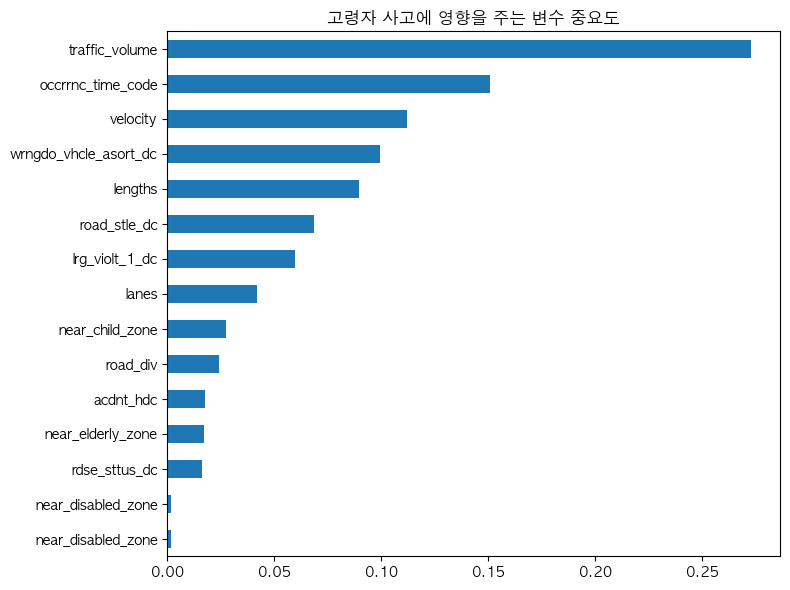

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# macOS용 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('./data/processed/accident_data_filtered.csv')

# 타겟 변수: 고령자 사고 여부
df["is_elderly_accident"] = df["acdnt_age_1_code"].apply(lambda x: 1 if x >= 65 else 0)
y = df["is_elderly_accident"]
# 자전거 제외
df = df[df["wrngdo_vhcle_asort_dc"] != "자전거"]
# 독립 변수
features = [
    'occrrnc_time_code', 'acdnt_hdc', 'road_stle_dc',
    'wrngdo_vhcle_asort_dc', 'rdse_sttus_dc', 'road_div',
    'near_disabled_zone', 'near_child_zone', 'near_elderly_zone', 'near_disabled_zone',
    'lanes', 'lengths', 'velocity', 'traffic_volume'
]
X = df[features].copy()

# 라벨 인코딩
label_cols = X.select_dtypes(include='object').columns
for col in label_cols:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])

# 모델 학습 (전체 데이터)
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X, y)

# 전체 데이터로 예측
y_pred = model.predict(X)

# 평가 결과 출력
print("📊 Classification Report (전체 데이터 기준):")
print(classification_report(y, y_pred))

# 변수 중요도 시각화
importances = model.feature_importances_
pd.Series(importances, index=features).sort_values().plot(kind='barh', figsize=(8, 6))
plt.title('고령자 사고에 영향을 주는 변수 중요도')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89     15249
           1       0.51      0.15      0.24      3769

    accuracy                           0.80     19018
   macro avg       0.67      0.56      0.56     19018
weighted avg       0.76      0.80      0.76     19018



In [9]:
df['velocity']

0        26.2
1        20.1
2        22.6
3        18.7
4        18.7
         ... 
95082    22.3
95083    16.5
95084    21.2
95085    21.1
95086    16.5
Name: velocity, Length: 95087, dtype: float64

In [10]:
df['traffic_volume'].describe()

count     88725.0
unique      432.0
top       67750.0
freq        910.0
Name: traffic_volume, dtype: float64

In [11]:
df.sort_values(by='velocity', ascending=False)

,acdnt_year,occrrnc_time_code,legaldong_name,acdnt_hdc,lrg_violt_1_dc,road_stle_dc,wrngdo_vhcle_asort_dc,acdnt_age_1_code,rdse_sttus_dc,road_div,...,near_elderly_zone,near_disabled_zone,lanes,lengths,velocity,traffic_volume,elderly_hotspot,non_elderly_hotspot,all_hotspot,is_elderly_accident
19101,2021,13,서울특별시 서초구 양재동,차대차,안전운전불이행,단일로 - 기타,승용,60,건조,102.0,...,0,0,10.0,12769.0,83.8,186278,NaN,1.0,1,0
18001,2021,12,서울특별시 서초구 양재동,차대차,안전운전불이행,교차로 - 교차로부근,이륜,51,건조,102.0,...,0,0,10.0,12769.0,83.8,150728,NaN,1.0,1,0
18030,2021,13,서울특별시 서초구 양재동,차대차,차로위반,단일로 - 기타,승용,56,건조,102.0,...,0,0,10.0,12769.0,83.8,150728,NaN,1.0,1,0
17337,2021,13,서울특별시 서초구 양재동,차대차,안전거리미확보,단일로 - 기타,화물,46,건조,102.0,...,0,0,10.0,12769.0,83.8,186278,NaN,1.0,1,0
50405,2022,12,서울특별시 서초구 양재동,차대차,안전거리미확보,단일로 - 기타,승용,57,건조,102.0,...,0,0,10.0,12769.0,83.5,153599.0,NaN,1.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95071,2023,17,서울특별시 중구 순화동,차대차,안전거리미확보,단일로 - 기타,승용,31,건조,104.0,...,0,0,NaN,NaN,NaN,18107.0,NaN,1.0,1,0
95073,2023,23,서울특별시 중구 신당동,차량단독,안전운전불이행,교차로 - 교차로부근,이륜,61,건조,104.0,...,0,0,NaN,NaN,NaN,56042.0,NaN,0.0,0,0
95074,2023,22,서울특별시 중구 신당동,차대차,안전운전불이행,교차로 - 교차로안,승용,54,젖음/습기,NaN,...,1,0,NaN,NaN,NaN,43085.0,NaN,1.0,0,0
95080,2023,16,서울특별시 중구 신당동,차대차,안전운전불이행,교차로 - 교차로부근,승용,51,건조,NaN,...,0,0,NaN,NaN,NaN,61995.0,NaN,0.0,0,0


/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_72743/3081675427.py:9: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/leejuan/Documents/GitHub/senior-road-risk-analyzer/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


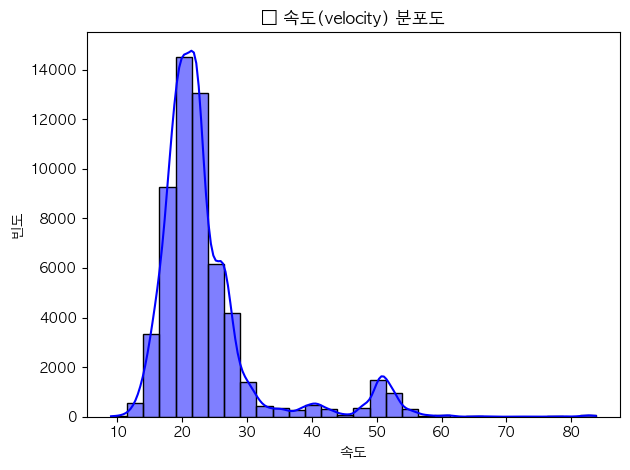

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예: 속도(velocity) 컬럼 분포
sns.histplot(df['velocity'], kde=True, bins=30, color='blue')
plt.title('🚗 속도(velocity) 분포도')
plt.xlabel('속도')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_72743/2395779465.py:15: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/leejuan/Documents/GitHub/senior-road-risk-analyzer/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


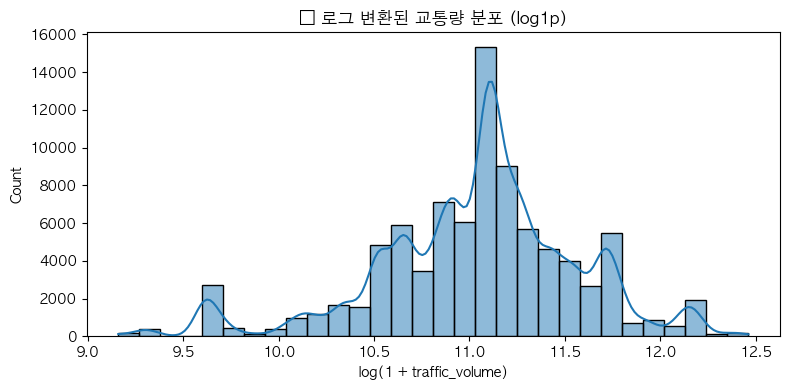

✅ 저장 완료: ./data/processed/accident_data_filtered.csv


In [22]:
# 1. 문자열을 숫자로 변환 (에러 무시하고 NaN 처리)
df['traffic_volume'] = pd.to_numeric(df['traffic_volume'], errors='coerce')

# 2. 로그 변환
df['log_traffic_volume'] = np.log1p(df['traffic_volume'])

# 3. 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(df['log_traffic_volume'].dropna(), kde=True, bins=30)
plt.title('📉 로그 변환된 교통량 분포 (log1p)')
plt.xlabel('log(1 + traffic_volume)')
plt.tight_layout()
plt.show()


# 변환된 컬럼 포함해서 저장
save_path = "./data/processed/accident_data_filtered.csv"
df.to_csv(save_path, index=False, encoding='utf-8-sig')

print("✅ 저장 완료:", save_path)

📊 Classification Report (전체 데이터 기준):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     75855
           1       0.93      0.98      0.96     19232

    accuracy                           0.98     95087
   macro avg       0.96      0.98      0.97     95087
weighted avg       0.98      0.98      0.98     95087



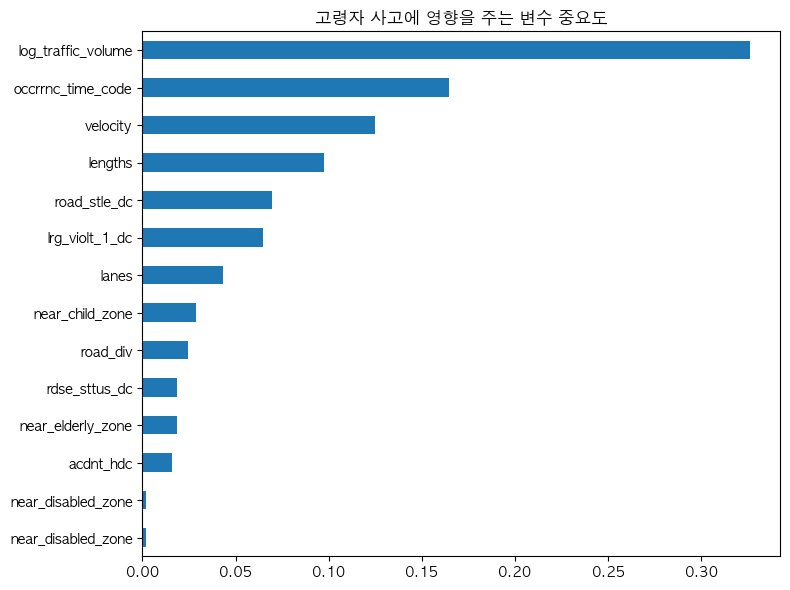

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# macOS용 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('./data/processed/accident_data_filtered.csv')

# 타겟 변수: 고령자 사고 여부
df["is_elderly_accident"] = df["acdnt_age_1_code"].apply(lambda x: 1 if x >= 65 else 0)
y = df["is_elderly_accident"]
# 자전거 제외
df = df[df["wrngdo_vhcle_asort_dc"] != "자전거"]
# 독립 변수
features = [
    'occrrnc_time_code', 'acdnt_hdc', 'lrg_violt_1_dc', 'road_stle_dc',
     'rdse_sttus_dc', 'road_div',
    'near_disabled_zone', 'near_child_zone', 'near_elderly_zone', 'near_disabled_zone',
    'lanes', 'lengths', 'velocity', 'log_traffic_volume'
]
X = df[features].copy()

# 라벨 인코딩
label_cols = X.select_dtypes(include='object').columns
for col in label_cols:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])

# 모델 학습 (전체 데이터)
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X, y)

# 전체 데이터로 예측
y_pred = model.predict(X)

# 평가 결과 출력
print("📊 Classification Report (전체 데이터 기준):")
print(classification_report(y, y_pred))

# 변수 중요도 시각화
importances = model.feature_importances_
pd.Series(importances, index=features).sort_values().plot(kind='barh', figsize=(8, 6))
plt.title('고령자 사고에 영향을 주는 변수 중요도')
plt.tight_layout()
plt.show()

/var/folders/0w/lqjy7dfj729d1lm1ynczx3nw0000gn/T/ipykernel_72743/1142132703.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/leejuan/Documents/GitHub/senior-road-risk-analyzer/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


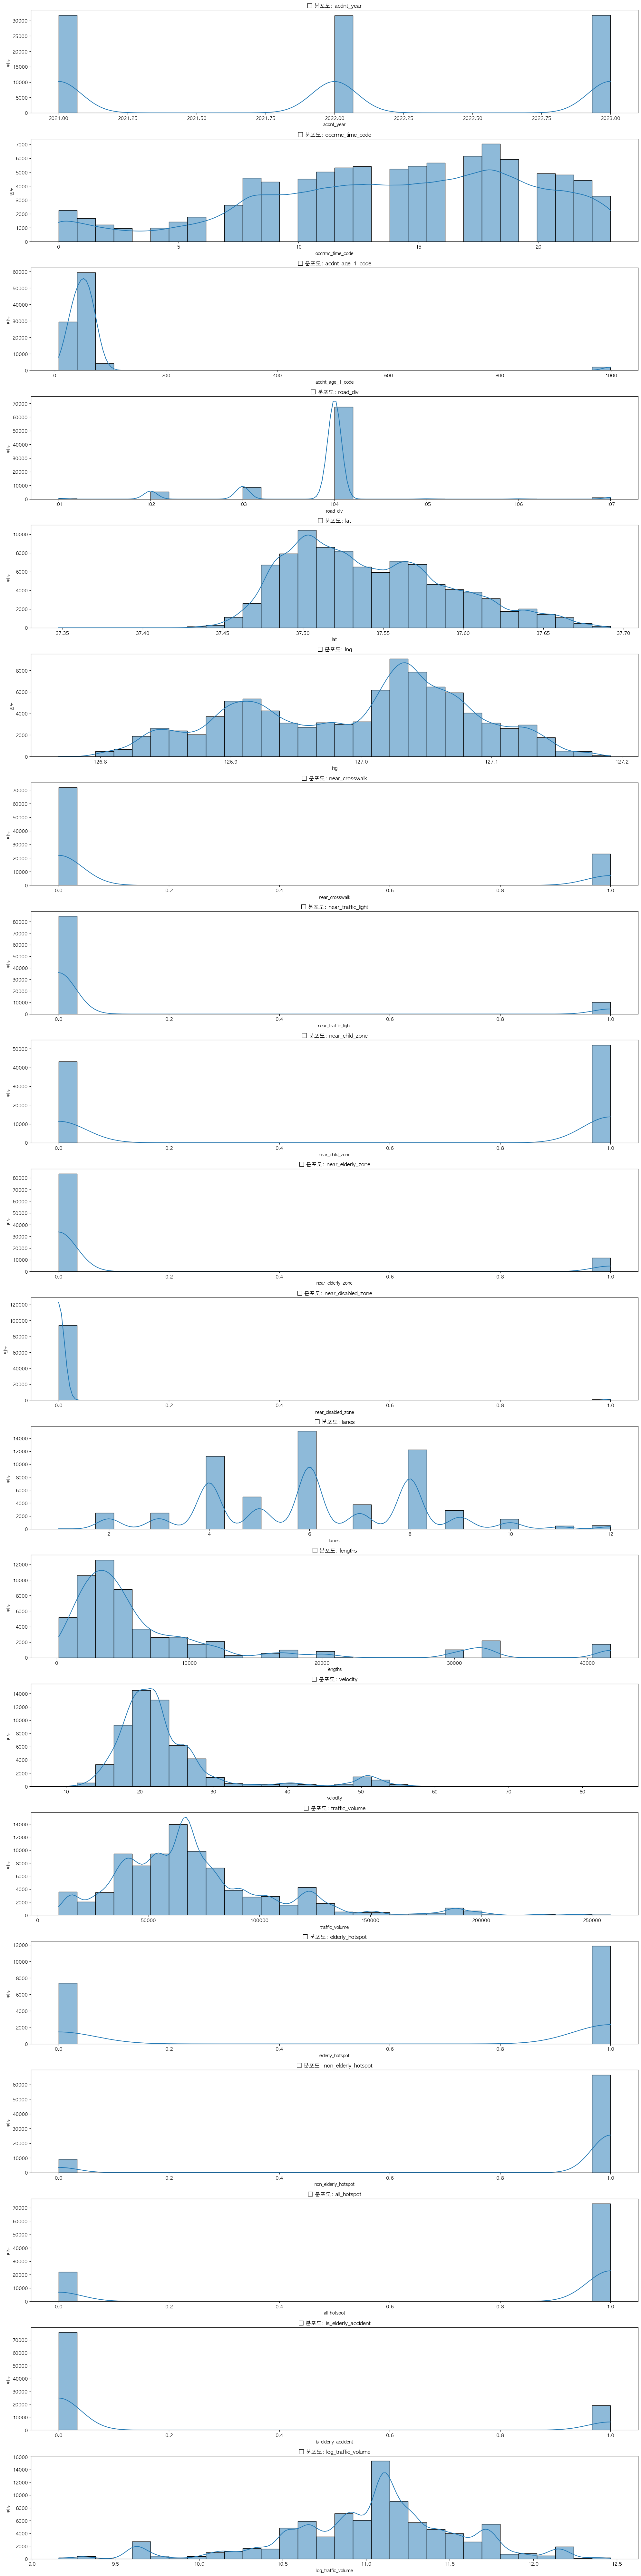

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 컬럼만 선택
numeric_cols = df.select_dtypes(include='number').columns

# 시각화
plt.figure(figsize=(20, 4 * len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols), 1, i + 1)
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f"📊 분포도: {col}")
    plt.xlabel(col)
    plt.ylabel("빈도")

plt.tight_layout()
plt.show()

🥇 상위 6개 중요 변수
	1.	log_traffic_volume    (통행량)
	2.	occrrnc_time_code     (사고 발생 시간대)
	3.	velocity              (사고 당시 속도)
	4.	wrngdo_vhcle_asort_dc (가해 차량 종류)
	5.	lengths               (도로 구간 길이)
	6.	road_stle_dc          (도로 형태)        